# Оптимизация управления персоналом в HR-компании "Работа с заботой".

**Задачи**


Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.   
   
Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Предоставленные данные**

id — уникальный идентификатор сотрудника;  
dept — отдел, в котором работает сотрудник;  
level — уровень занимаемой должности;  
workload — уровень загруженности сотрудника;  
employment_years — длительность работы в компании (в годах);  
last_year_promo — показывает, было ли повышение за последний год;  
last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;  
supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;  
salary — ежемесячная зарплата сотрудника;  
job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.  

**Шаг 1. Загрузка данных**

In [1]:
!pip install -Uq scikit-learn
!pip install shap -q
!pip install phik -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 6.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
import shap
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer


In [3]:
df_train = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
df_test = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
df_test_target = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

**Шаг 2. Предобработка данных**

In [4]:
df_train.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [5]:
df_test.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [6]:
df_test_target.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [9]:
df_test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Типы данных соответстыуют представленным в столбцах.

In [10]:
df_train.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

В столбцах с данными dept  и level  6 и 4 пропуска соответственно.

In [11]:
df_test.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

В столбцах с данными dept и level 2 и 1 пропуск соответственно.

In [12]:
for col in df_train.iloc[:, 1:8]:
   print(df_train[col].unique())

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
[ 2  1  4  7  9  6  3 10  8  5]
['no' 'yes']
['no' 'yes']
[1 5 2 3 4]


In [13]:
for col in df_test.iloc[:, 1:7]:
   print(df_test[col].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
[ 2  1  5  6  3  9  7  4  8 10]
['no' 'yes']
['no' 'yes']


In [14]:
duplicate_id_train = df_train[df_train.duplicated(['id'])]
duplicate_id_train

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate


In [15]:
duplicate_id_test = df_test[df_test.duplicated(['id'])]
duplicate_id_test

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


In [16]:
duplicate_id_target = df_test_target[df_test_target.duplicated(['id'])]
duplicate_id_target

,id,job_satisfaction_rate


Дубликатов в столбце с id сотрудников нет ни в одном из трех датафреймов.


**Шаг 3. Исследовательский анализ данных**

In [17]:
def histagram(name, col, title, x, y):
    total = len(name)
    name_grouped = name.groupby(col).size()/total
    name_grouped_sorted = name_grouped.sort_values()
    diagram = name_grouped_sorted.plot(kind='bar', figsize=(14,6))
    plt.title(f'{title}', fontsize=14)
    plt.xlabel(f'{x}', fontsize=14)
    plt.ylabel(f'{y}', fontsize=14)


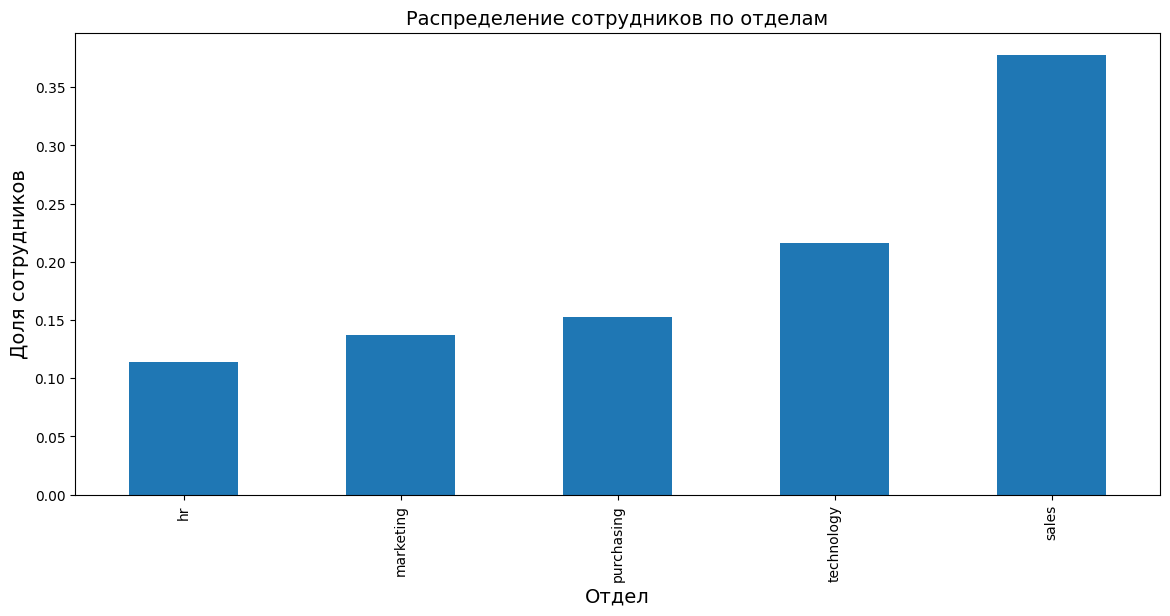

In [18]:
name = df_train
col = "dept"
title = "Распределение сотрудников по отделам"
x = "Отдел"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

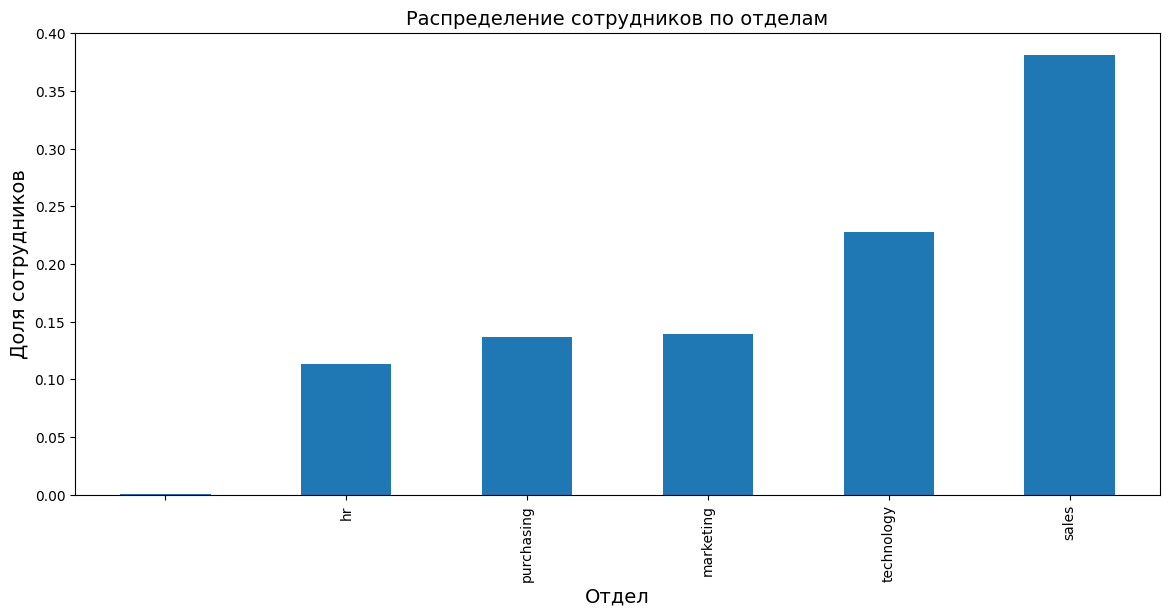

In [19]:
name = df_test
col = "dept"
title = "Распределение сотрудников по отделам"
x = "Отдел"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Больше всего сотрудников работает в отделе продаж, примерно, 37%. Меньше всего в отделе по подбору персонала, примерно, 12%.

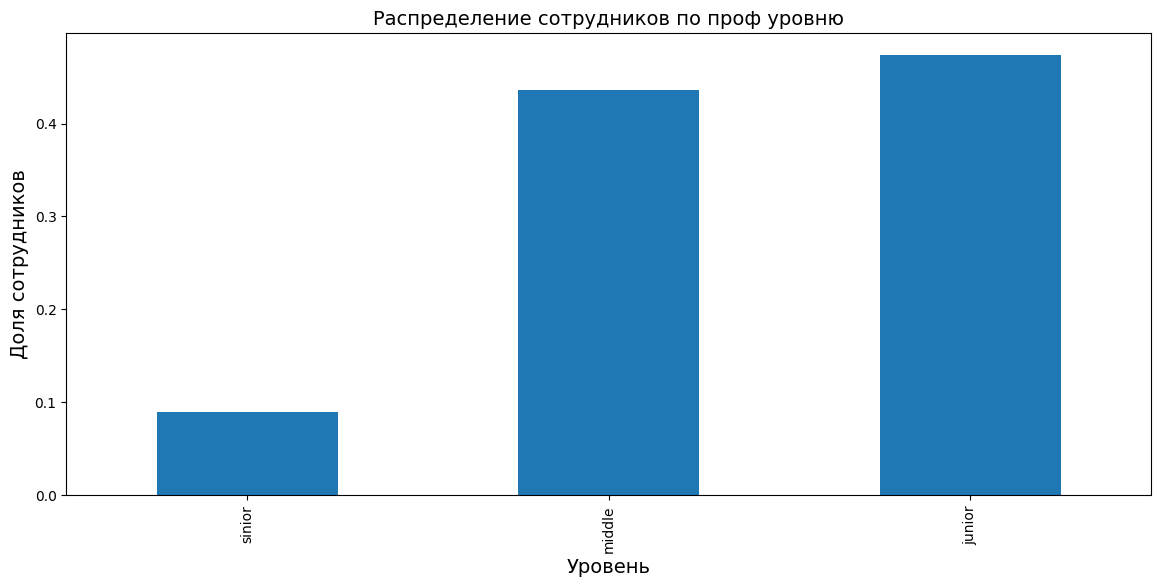

In [20]:
name = df_train
col = "level"
title = "Распределение сотрудников по проф уровню"
x = "Уровень"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

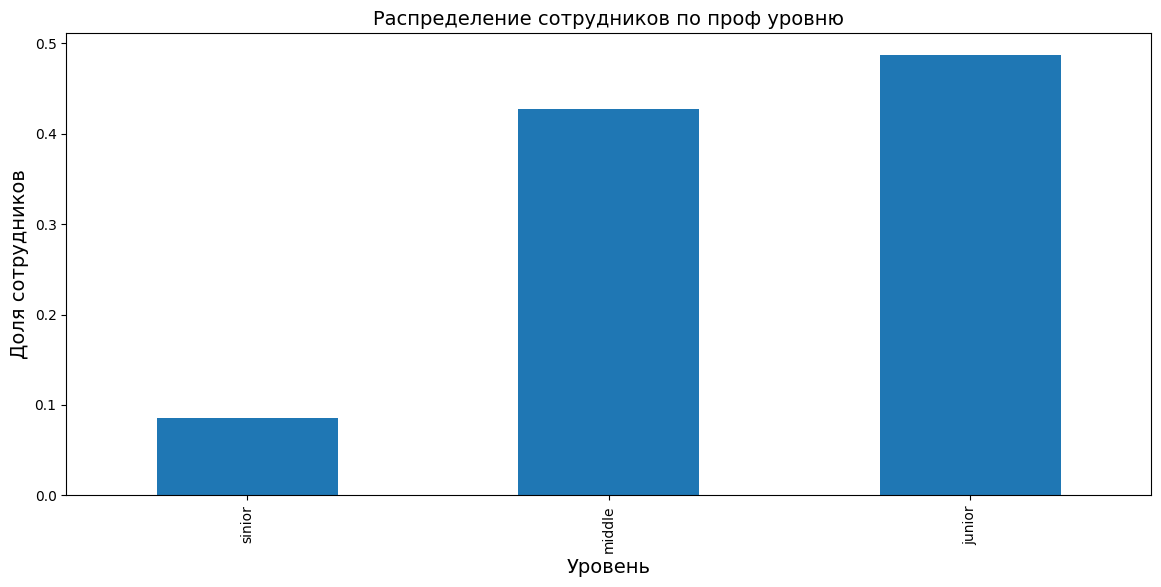

In [21]:
name = df_test
col = "level"
title = "Распределение сотрудников по проф уровню"
x = "Уровень"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Джуниоров больше всего, практически половина от всех сотрудников, но мидлов, также, достаточно много, около 42%.

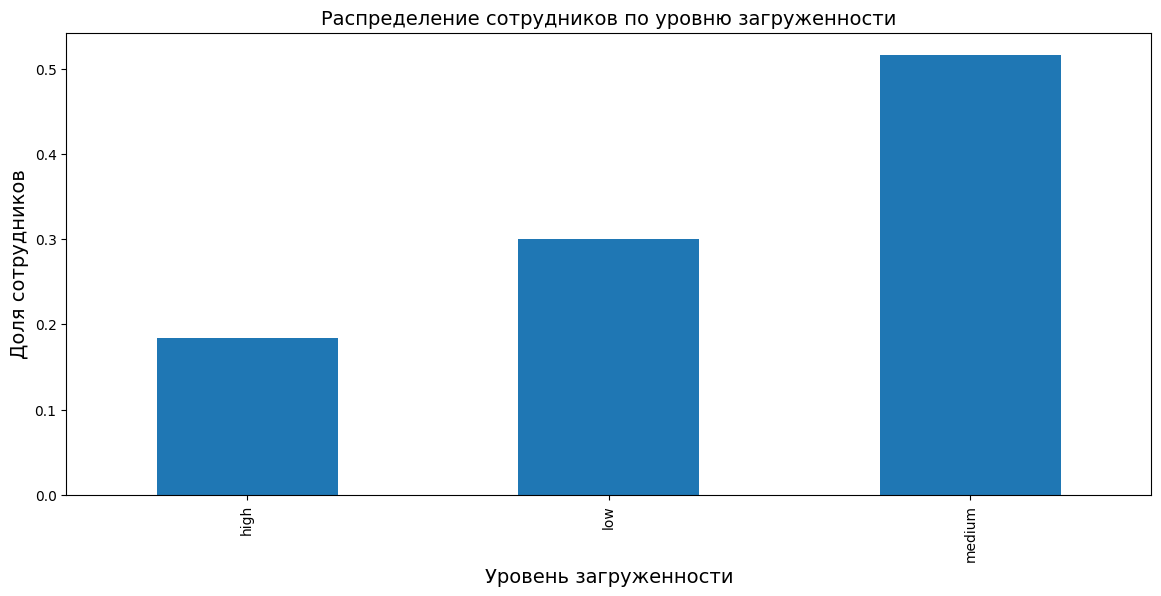

In [22]:
name = df_train
col = "workload"
title = "Распределение сотрудников по уровню загруженности"
x = "Уровень загруженности"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

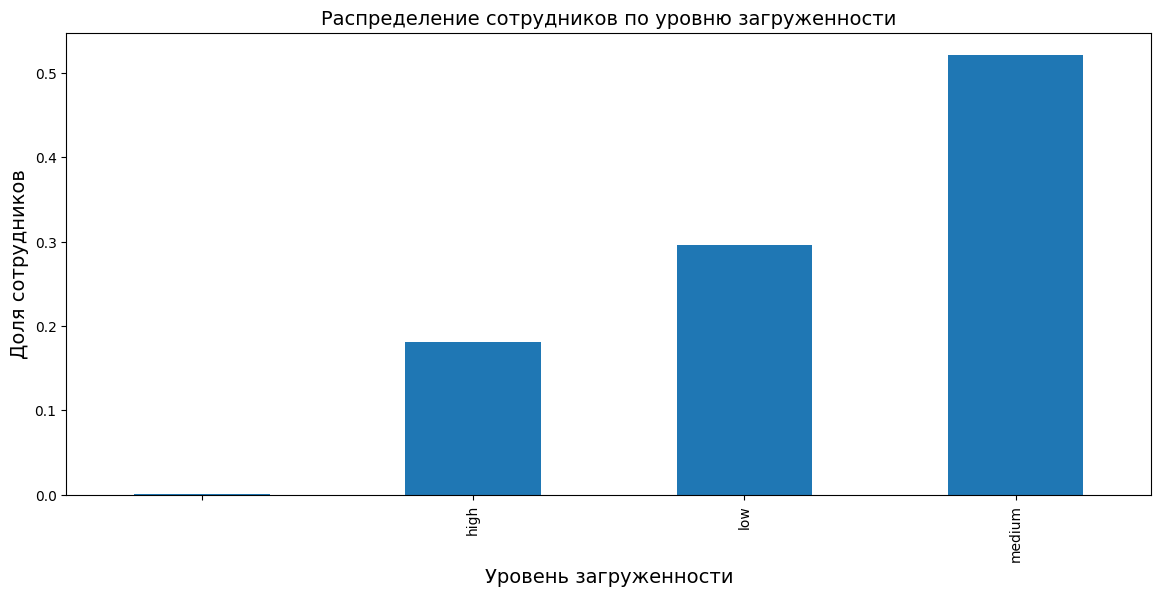

In [23]:
name = df_test
col = "workload"
title = "Распределение сотрудников по уровню загруженности"
x = "Уровень загруженности"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Чуть более половины сотрудников средне загружены на работе. Но практически 20% - с высоким уровнем загруженности.В тестовом датафрейме есть пропуски, от которых мы позже избавимся.

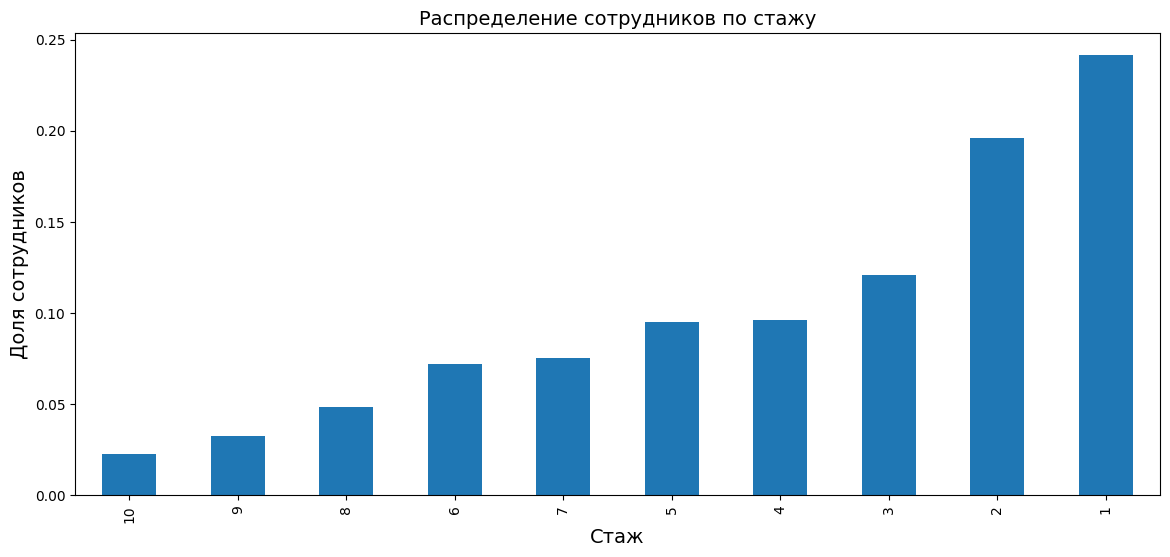

In [24]:
name = df_train
col = "employment_years"
title = "Распределение сотрудников по стажу"
x = "Стаж"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

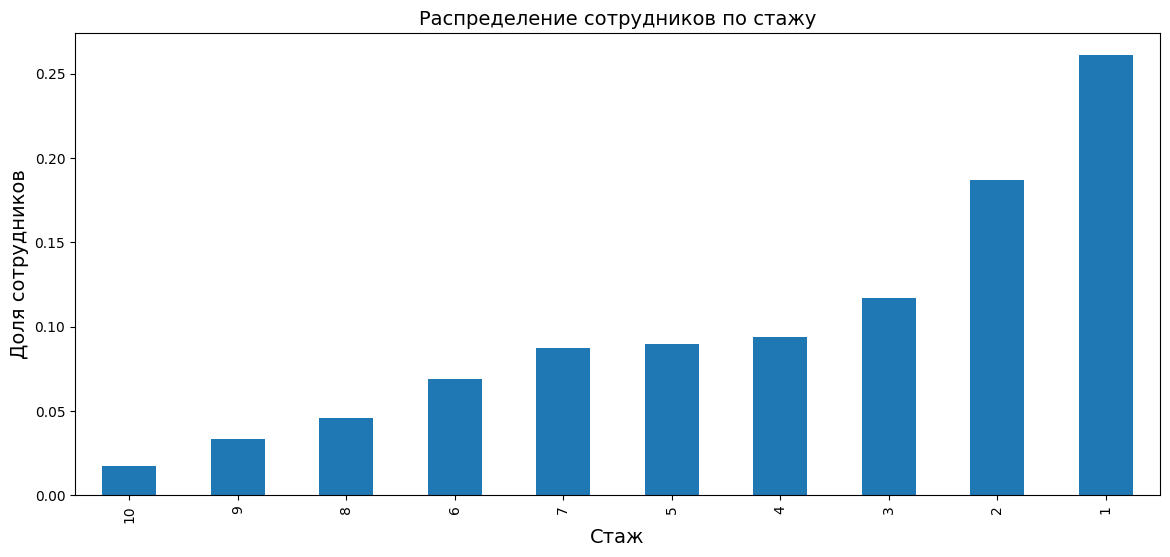

In [25]:
name = df_test
col = "employment_years"
title = "Распределение сотрудников по стажу"
x = "Стаж"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Больше всего сотрудников с 1 и 2-годичным стажем, 10 лет в компании проработало около двух с половиной процентов от всех сотрудников.

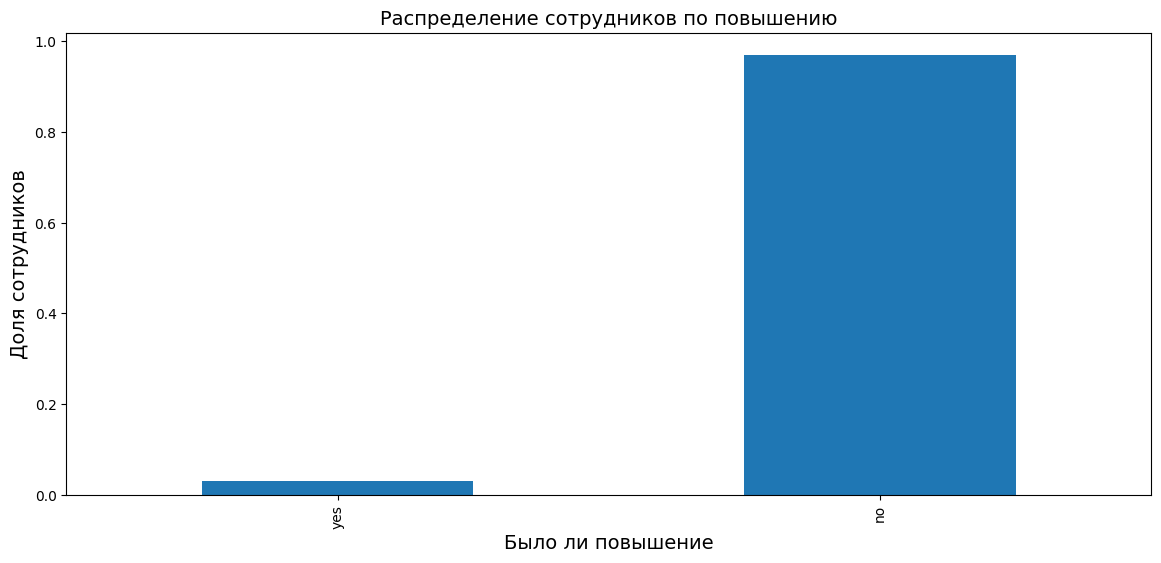

In [26]:
name = df_train
col = "last_year_promo"
title = "Распределение сотрудников по повышению"
x = "Было ли повышение"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

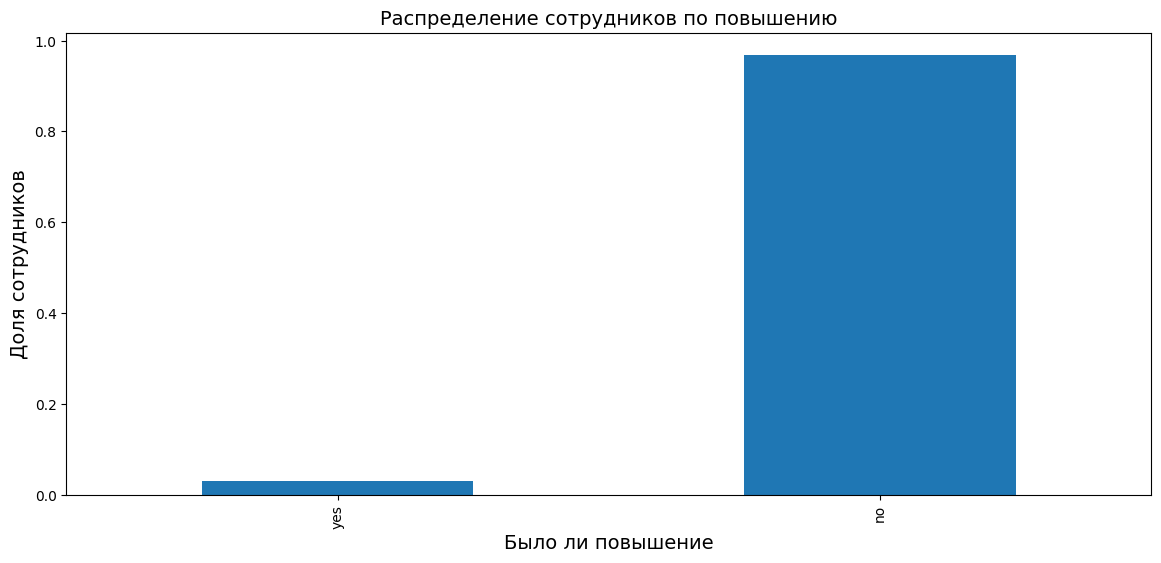

In [27]:
name = df_test
col = "last_year_promo"
title = "Распределение сотрудников по повышению"
x = "Было ли повышение"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Только менее, чем у 1% сотрудников было повышение за последний год.

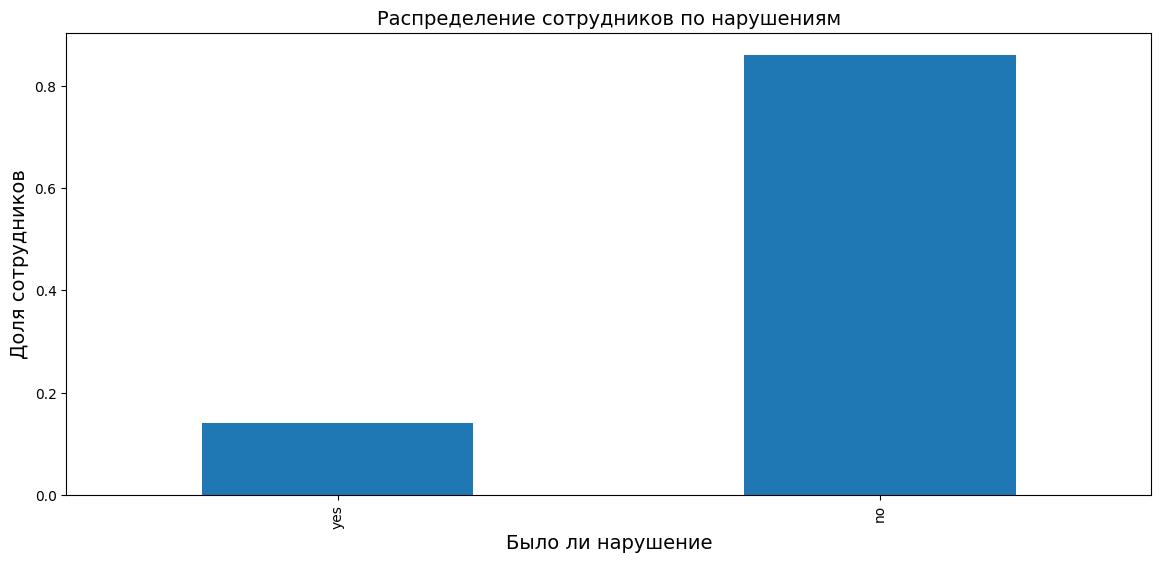

In [28]:
name = df_train
col = "last_year_violations"
title = "Распределение сотрудников по нарушениям"
x = "Было ли нарушение"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

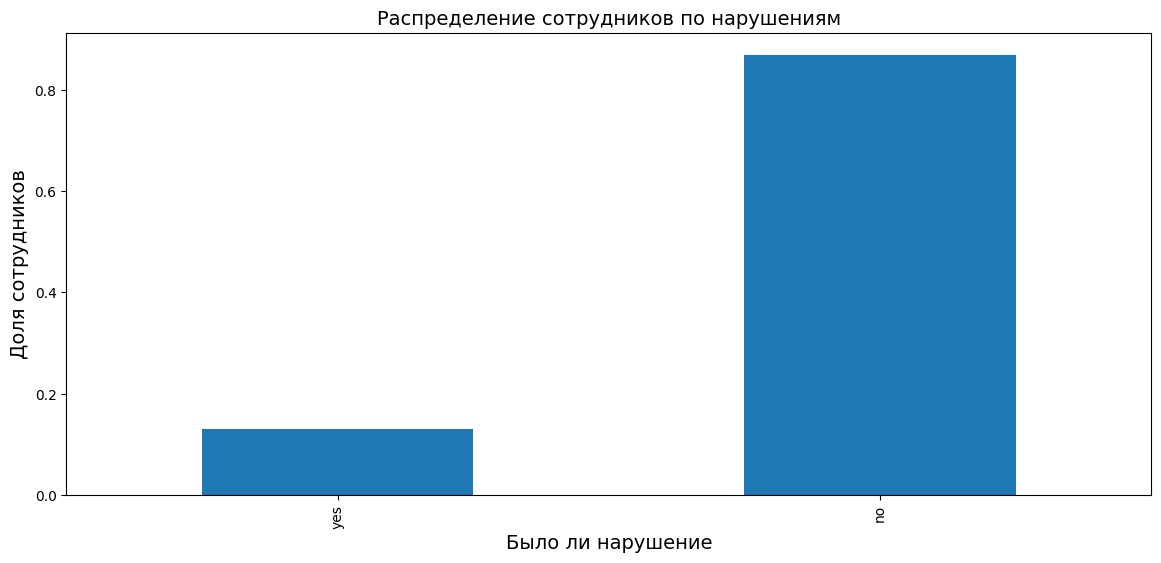

In [29]:
name = df_test
col = "last_year_violations"
title = "Распределение сотрудников по нарушениям"
x = "Было ли нарушение"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Более 80% сотрудников не нарушало трудовой договор за последний год.

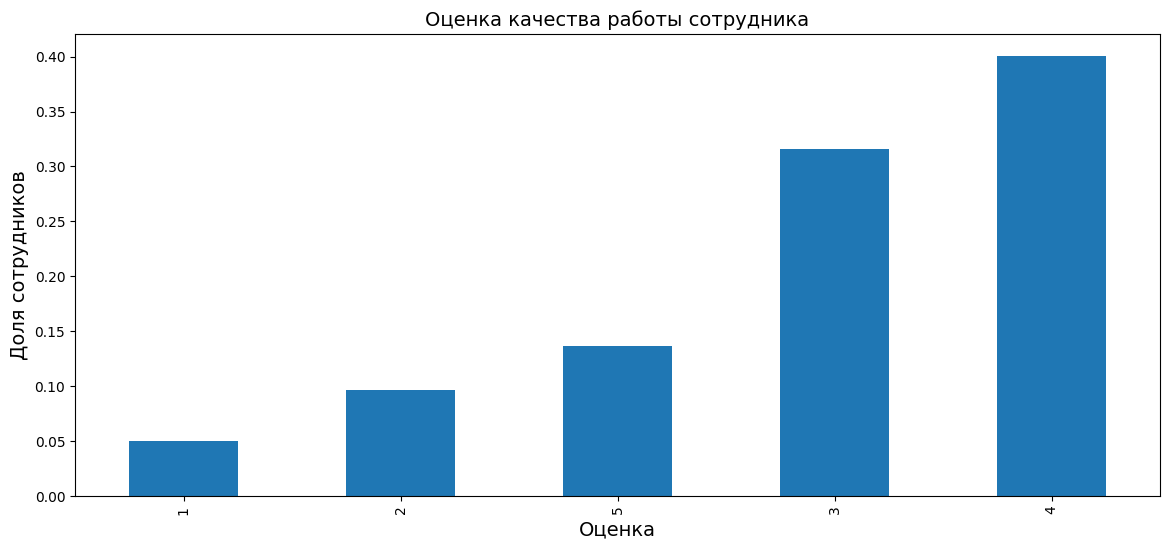

In [30]:
name = df_train
col = "supervisor_evaluation"
title = "Оценка качества работы сотрудника"
x = "Оценка"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

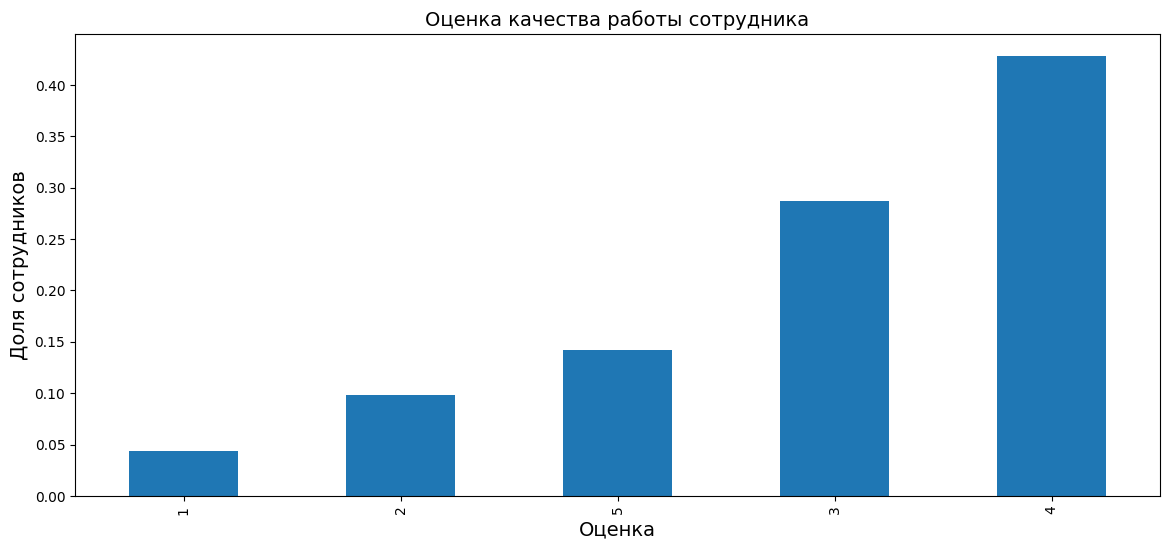

In [31]:
name = df_test
col = "supervisor_evaluation"
title = "Оценка качества работы сотрудника"
x = "Оценка"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Руководители в большинстве случаев оценивают работу своих сотрудников 3 и 4 баллами. 5% сотрудников получили наименьший балл - 1.

In [32]:
def hist(name, col, title, x, y):
    ax = name[col].plot(kind='hist', bins=40,figsize=(15,7))
    ax.set_xlabel(x, fontsize=14)
    ax.set_ylabel(y, fontsize=14)

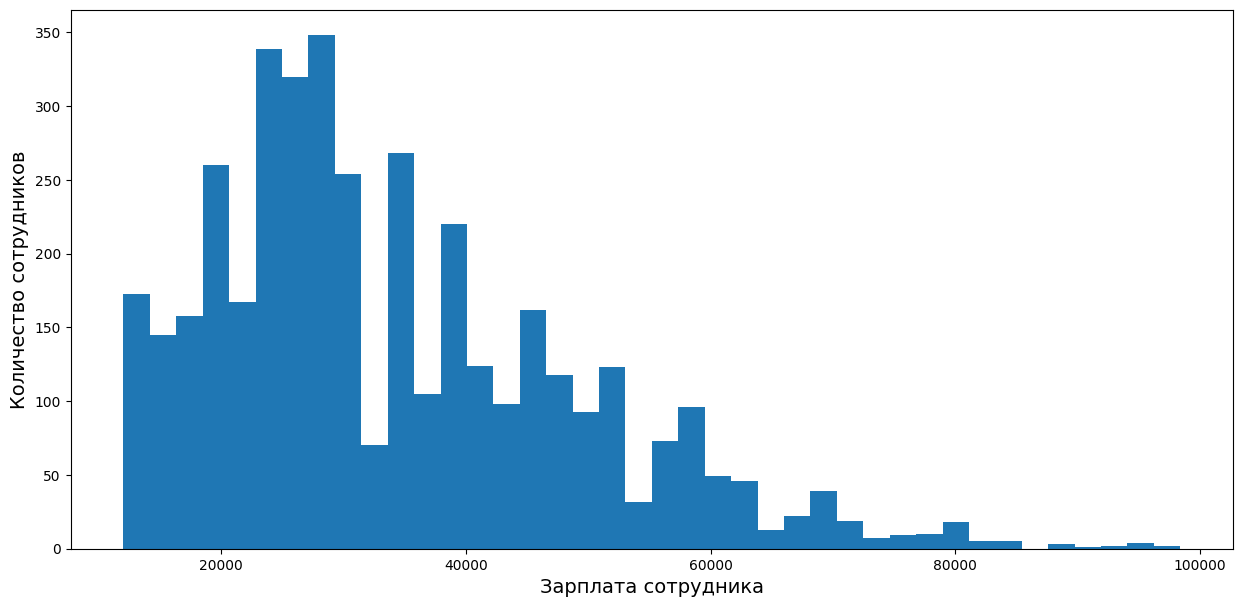

In [33]:
name = df_train
col = "salary"
title = "Ежемесячная зарплата сотрудника"
x = "Зарплата сотрудника"
y = "Количество сотрудников"
hist(name, col, title, x, y)

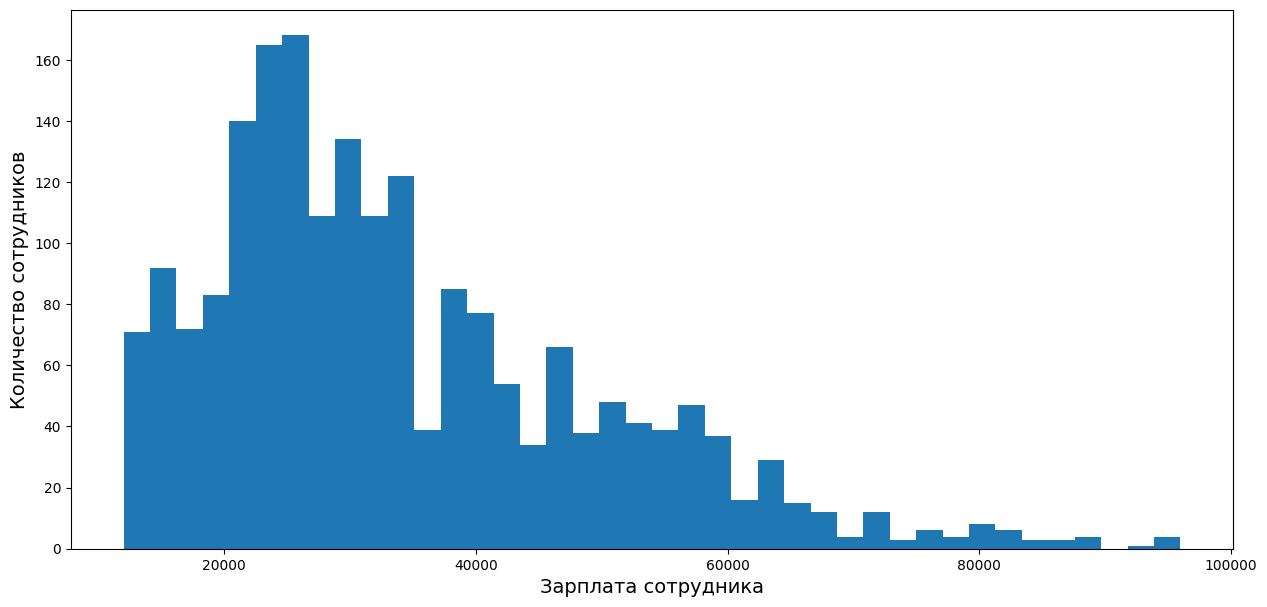

In [34]:
name = df_test
col = "salary"
title = "Ежемесячная зарплата сотрудника"
x = "Зарплата сотрудника"
y = "Количество сотрудников"
hist(name, col, title, x, y)

Чаще всего среди сотрудников встречается заработная плата до 30000 руб.

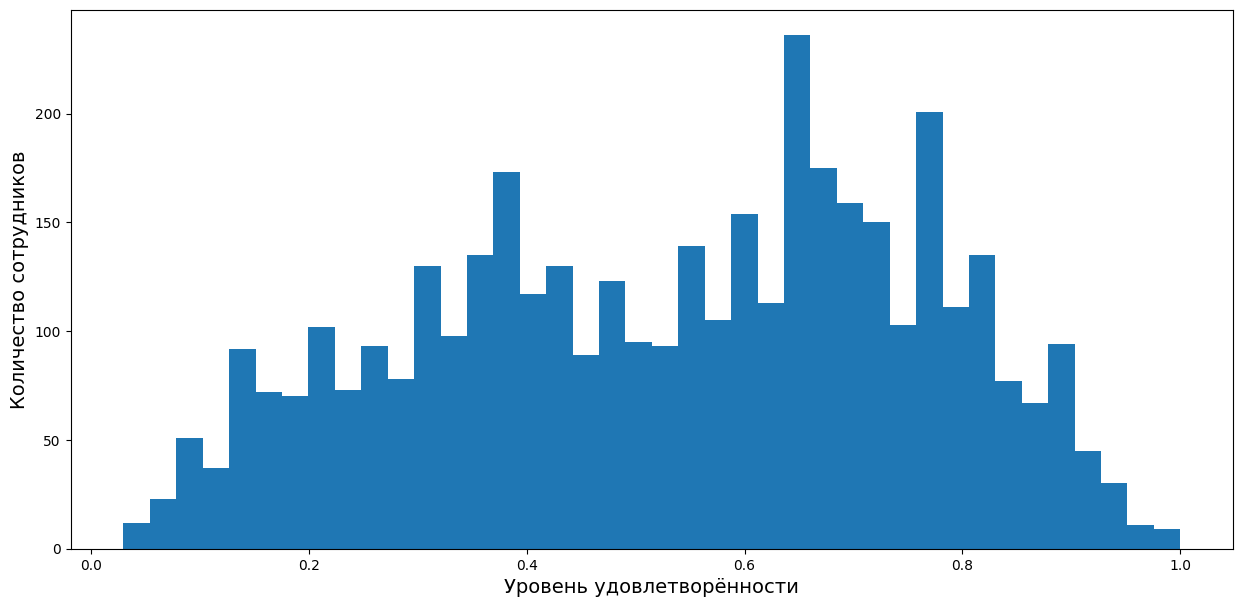

In [35]:
name = df_train
col = "job_satisfaction_rate"
title = "Уровень удовлетворённости сотрудника работой"
x = "Уровень удовлетворённости"
y = "Количество сотрудников"
hist(name, col, title, x, y)

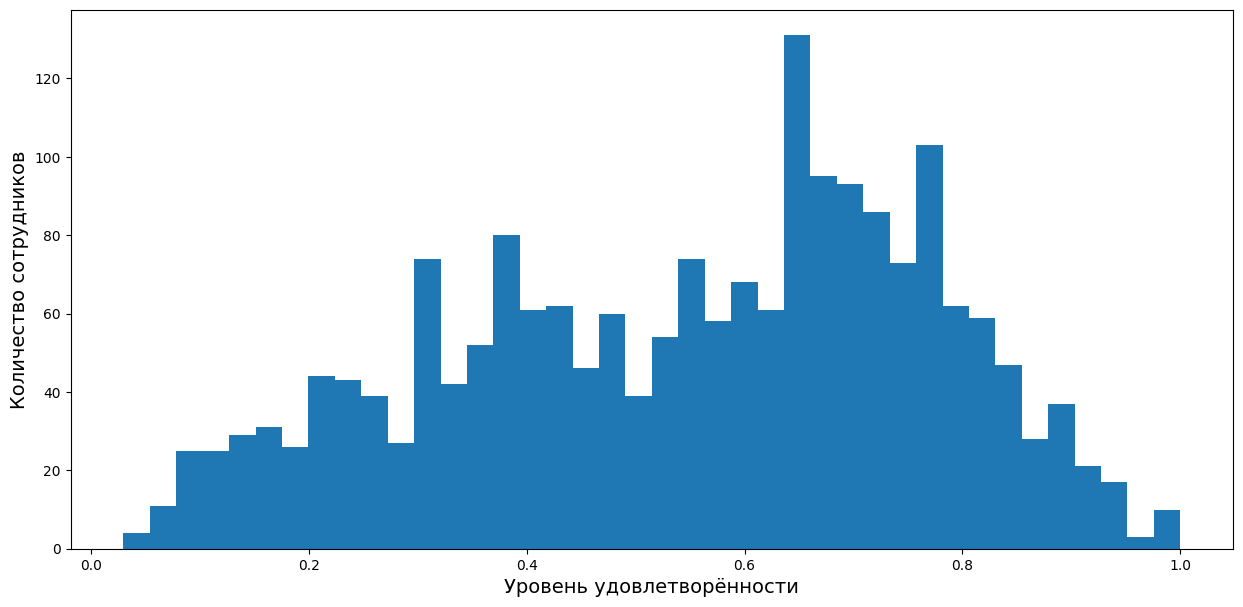

In [36]:
name = df_test_target
col = "job_satisfaction_rate"
title = "Уровень удовлетворённости сотрудника работой"
x = "Уровень удовлетворённости"
y = "Количество сотрудников"
hist(name, col, title, x, y)

Выделяется три пика оценок - 0.4, 0.7, 0.8.

In [37]:
df_train.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [38]:
df_test.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [39]:
df_test_target.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


In [40]:
def plot(df, col, title):
   df.boxplot(column=[col], grid= False, fontsize=14)
   plt.title(f'{title}', fontsize=10, fontweight="bold")
   plt.show()


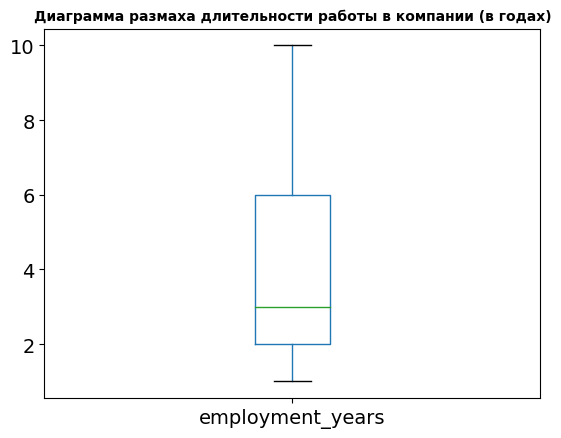

In [41]:
df = df_train
col = 'employment_years'
title = 'Диаграмма размаха длительности работы в компании (в годах)'
plot(df, col, title)

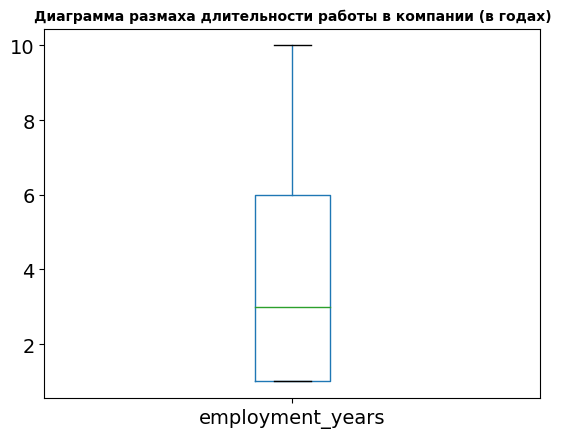

In [42]:
df = df_test
col = 'employment_years'
title = 'Диаграмма размаха длительности работы в компании (в годах)'
plot(df, col, title)

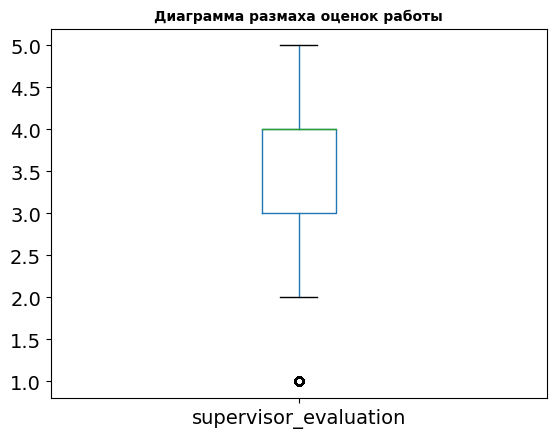

In [43]:
df = df_train
col = 'supervisor_evaluation'
title = 'Диаграмма размаха оценок работы'
plot(df, col, title)

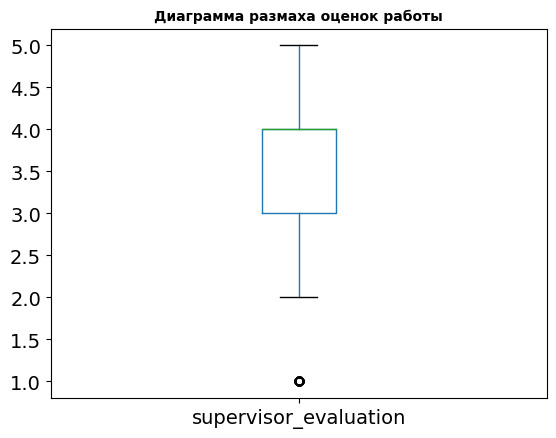

In [44]:
df = df_test
col = 'supervisor_evaluation'
title = 'Диаграмма размаха оценок работы'
plot(df, col, title)

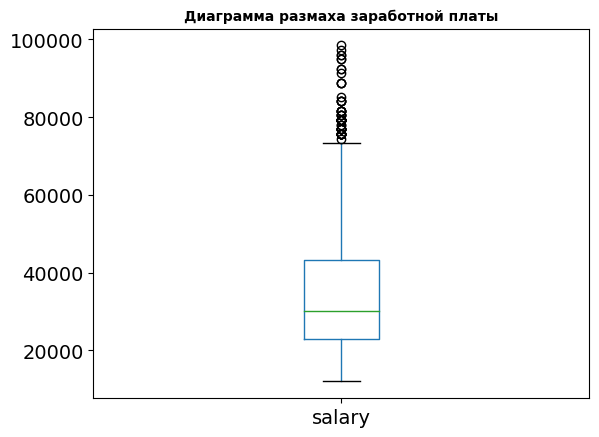

In [45]:
df = df_train
col = 'salary'
title = 'Диаграмма размаха заработной платы'
plot(df, col, title)

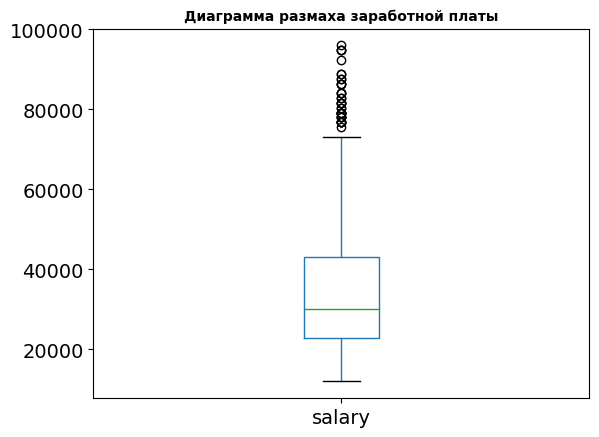

In [46]:
df = df_test
col = 'salary'
title = 'Диаграмма размаха заработной платы'
plot(df, col, title)

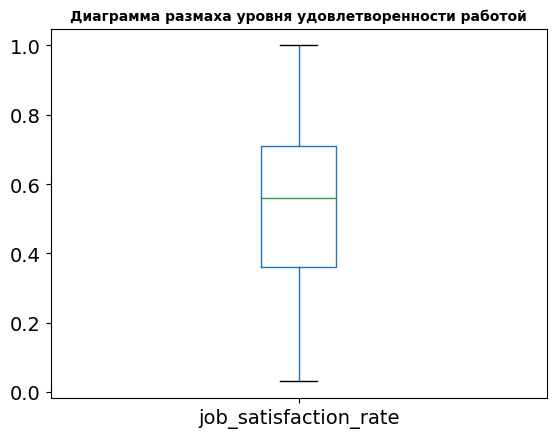

In [47]:
df = df_train
col = 'job_satisfaction_rate'
title = 'Диаграмма размаха уровня удовлетворенности работой'
plot(df, col, title)

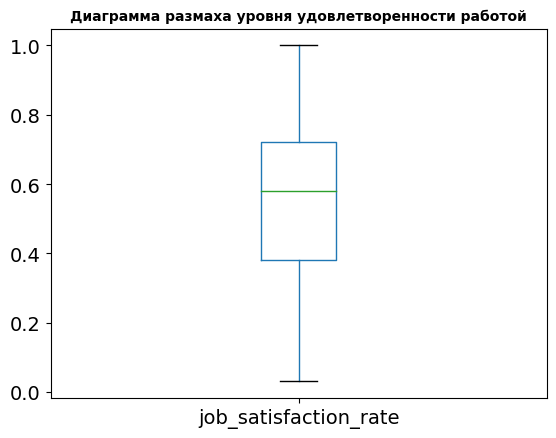

In [48]:
df = df_test_target
col = 'job_satisfaction_rate'
title = 'Диаграмма размаха уровня удовлетворенности работой'
plot(df, col, title)

Во всех столбцах с количественными признаками выбросов не обнаружено.

Так как корреляция Пирсона измеряет степень и направление линейных корреляций между переменными, а у нас зависимости между признаками нелинейные, нам подойдет корреляция Фи.

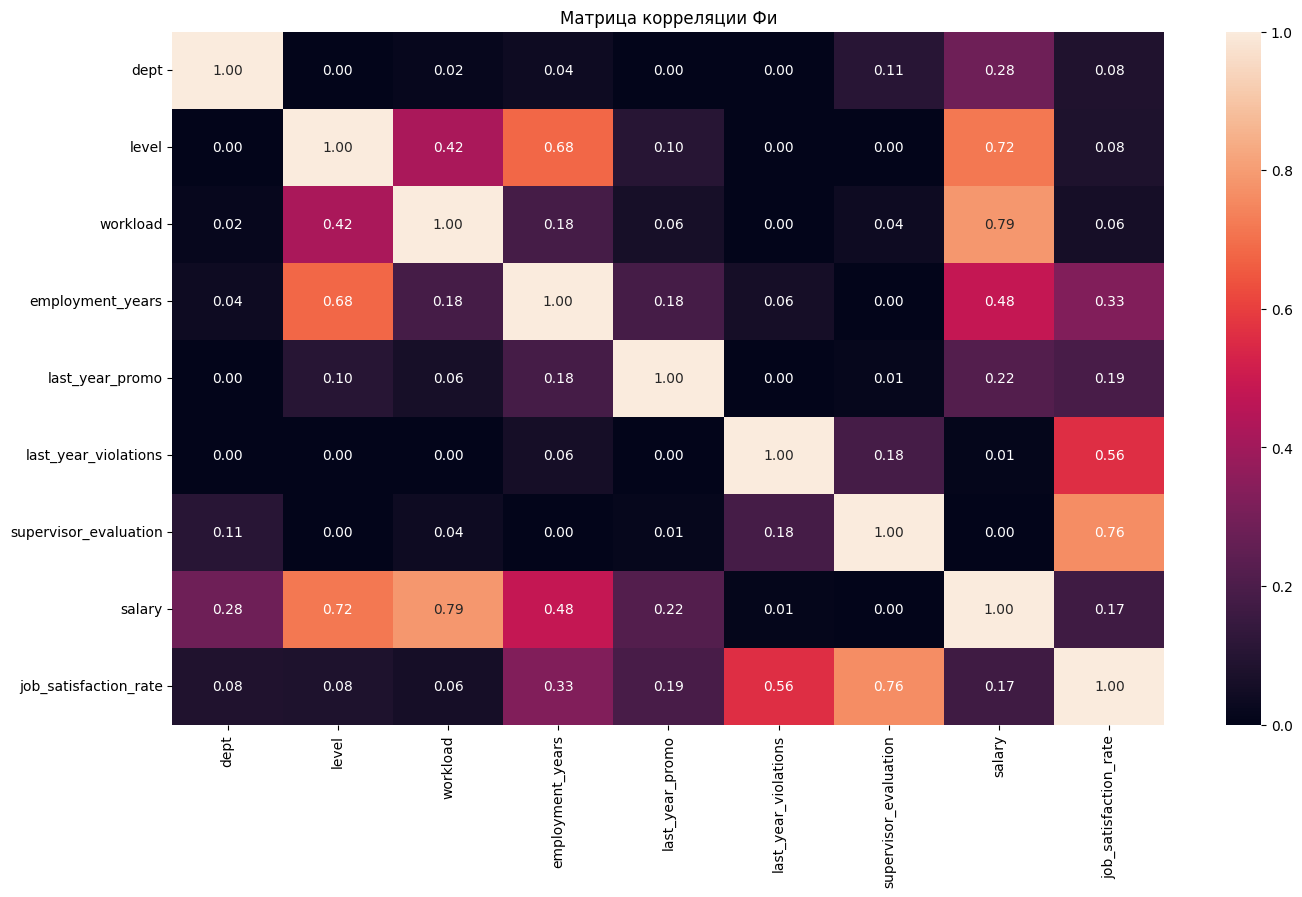

In [49]:
df_train_without_id = df_train.set_index('id')
interval_cols = ['salary', 'job_satisfaction_rate']
phik_matrix = df_train_without_id.phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(16, 9))
sns.heatmap(phik_matrix, annot=True, fmt=".2f")
plt.title("Матрица корреляции Фи")
plt.show()

Сильная положительная связь между признаками наблюдается между:    
- з/п и уровнем занимаемой должности,  
- з/п и уровнем загруженности сотрудника,  
- оценкой работы и уровнем удовлетворения работой.  

Умеренная положительная связь между признаками наблюдается между:  
- з/п и стажем в компании,  
- уровнем удовлетворения работой и стажем в компании,  
- уровнем удовлетворения работой и нарушением трудового договора,  
- стажем в компании и уровнем занимаемой должности,  
- уровнем загруженности сотрудника и департаментом.  

Между остальными признаками наблюдается слабая положительная связь.

Мультиколлинеарности не наблюдается.



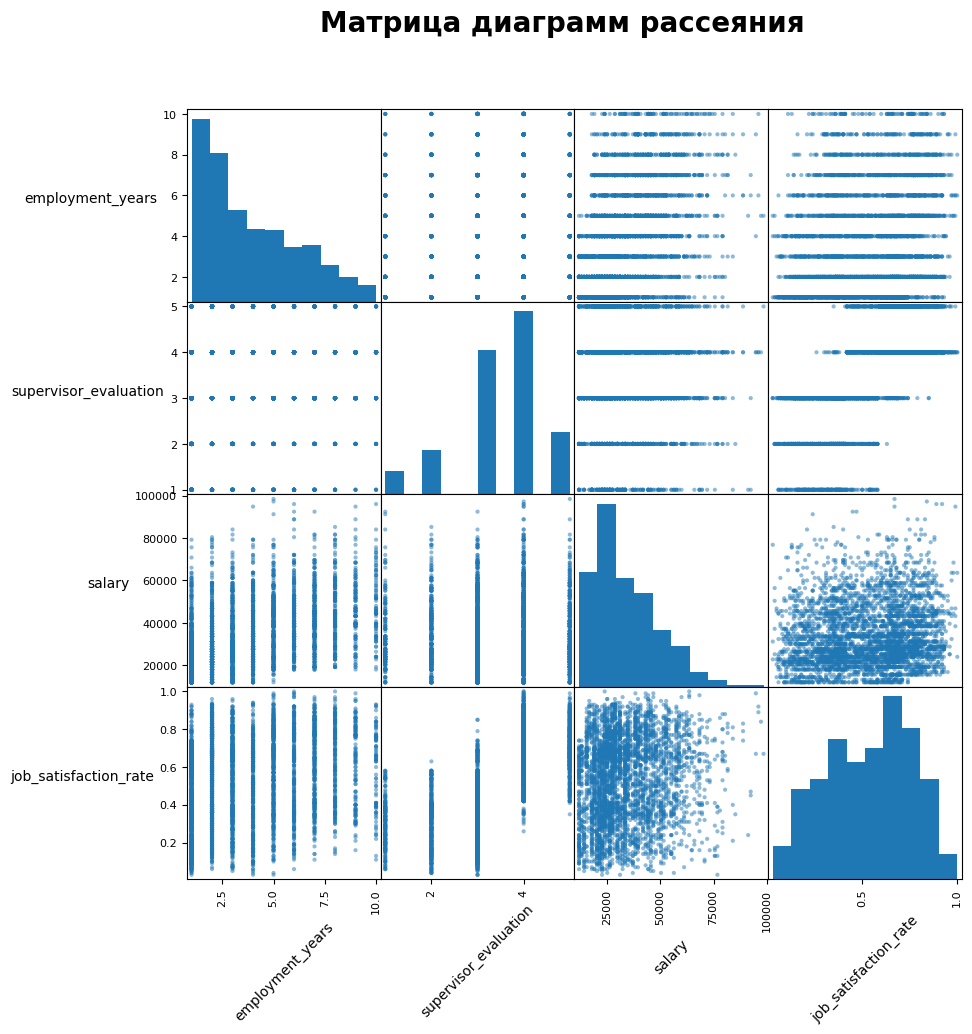

In [50]:
axes = pd.plotting.scatter_matrix(df_train_without_id, figsize=(10, 10))

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.suptitle('Матрица диаграмм рассеяния', fontsize=20, fontweight="bold")
plt.show()

Значимых замечаний в данных во время исследовательского анализа мной не выявлено.


**Шаг 4. Подготовка данных**

In [53]:
df_test_final = df_test.merge(df_test_target, on = 'id', how ='left')
df_test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 156.4+ KB


<div class="alert alert-warning">
<b>Комментарий 👉</b>

В случае объединения/слияния датафреймов рекомендую тебе смотреть на размерости датафреймов ДО слияния и ПОСЛЕ него. В подобных операциях часто ошибки бывают.
</div>

In [54]:
df_test_final = df_test_final.drop(['id'], axis=1)

In [55]:
df_test_final.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,marketing,junior,medium,2,no,no,5,28800,0.79
1,hr,junior,medium,1,no,no,4,30000,0.72
2,sales,middle,low,5,no,no,4,19200,0.64
3,sales,middle,low,6,no,no,4,19200,0.60
4,hr,middle,medium,5,no,no,5,40800,0.75


In [56]:
df_train_without_id = df_train.drop(['id'], axis=1)

In [57]:
df_train_without_id.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,junior,medium,2,no,no,1,24000,0.58
1,hr,junior,high,2,no,no,5,38400,0.76
2,sales,junior,low,1,no,no,2,12000,0.11
3,technology,junior,low,4,no,no,2,18000,0.37
4,hr,junior,medium,1,no,no,3,22800,0.20


In [58]:
df_train.drop_duplicates(inplace=True)

In [59]:
X_train = df_train_without_id.drop(['job_satisfaction_rate'], axis=1)

In [60]:
y_train = df_train_without_id['job_satisfaction_rate']

In [61]:
X_test = df_test_final.drop(['job_satisfaction_rate'], axis=1)

In [62]:
y_test = df_test_final['job_satisfaction_rate']

In [63]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

param_grid1 = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE, max_features=11, min_samples_leaf=5)],
        'models__max_depth': range(2,20),
        'models__min_samples_split': range(2,25),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsRegressor()
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2, 25),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },


]



**Шаг 5. Обучение моделей**

In [64]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]


def smape(y_true, y_pred):
    return 1/len(y_true) * np.sum(2 * np.abs(y_pred-y_true) / (np.abs(y_true) + np.abs(y_pred))*100)
smape_scorer = make_scorer(smape, greater_is_better=False)

grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv=5,
    scoring=smape_scorer
)


In [65]:
grid_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print(f'Метрика лучшей модели на кросс-валидации: {-1*grid_search.best_score_:.2f}')
y_test_pred = grid_search.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {smape(y_test, y_test_pred):.2f}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [66]:
print('Гиперпараметры', grid_search.best_params_)

Гиперпараметры {'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 13, 'models__max_features': 11, 'preprocessor__num': MinMaxScaler()}


Так как критериями успеха модели были показатели SMAPE ≤ 15 на тестовой выборке, а у нас получилось 14.28 - модель DecisionTreeRegressor с параметрами random_state=42, models__max_depth: 13, odels__max_features: 11, preprocessor__num: MinMaxScaler можно брать в работу.

**Шаг 6. Оформление выводов**

1. В начале работы был проведен анализ данных и выявлены следующие закономерности в признаках:  
Сильная положительная связь между признаками наблюдается между:

з/п и уровнем занимаемой должности,    
з/п и уровнем загруженности сотрудника,  
оценкой работы и уровнем удовлетворения работой.  

Умеренная положительная связь между признаками наблюдается между:  

з/п и стажем в компании,  
уровнем удовлетворения работой и стажем в компании,   
уровнем удовлетворения работой и нарушением трудового договора,  
стажем в компании и уровнем занимаемой должности,  
уровнем загруженности сотрудника и департаментом.  
Между остальными признаками наблюдается слабая положительная связь.  

Мультиколлинеарности не наблюдается.  

2. На основе метрики SMAPE была отобрана лучшая модель  
DecisionTreeRegressor  
с параметрами random_state=42, models__max_depth: 13, odels__max_features: 11,
preprocessor__num: MinMaxScaler.  

3. Метрика лучшей модели на тренировочной выборке: 15.01  

4. Метрика SMAPE на тестовой выборке: 14.28

#Задача 2: предсказание увольнения сотрудника из компании

**Шаг 1. Загрузка данных**

Так как тестовые входные данные остаются теми же, загрузим только тестовые целевые данные и тренировочный датафрейм.

In [67]:
train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
test_quit_target = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

**Шаг 2. Предобработка данных**

In [68]:
train_quit.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [69]:
test_quit_target.head(5)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [70]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [71]:
test_quit_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [72]:
train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [73]:
test_quit_target.isna().sum()

id      0
quit    0
dtype: int64

Пропусков в датафреймах нет и все столбцы имеют соответствующий данным тип.

In [74]:
for col in train_quit.iloc[:, 1:8]:
   print(train_quit[col].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
[ 2  5  1  8  4  7  3  9  6 10]
['no' 'yes']
['no' 'yes']
[4 1 3 5 2]


In [75]:
for col in test_quit_target.iloc[:, 1:8]:
   print(test_quit_target[col].unique())

['yes' 'no']


In [76]:
duplicated_id_1 = train_quit[train_quit.duplicated(['id'])]
duplicated_id_1

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit


In [77]:
duplicated_id_2 = test_quit_target[test_quit_target.duplicated(['id'])]
duplicated_id_2

,id,quit


Дубликатов и пропусков в данных не обнаружено.

**Шаг 3. Исследовательский анализ данных**

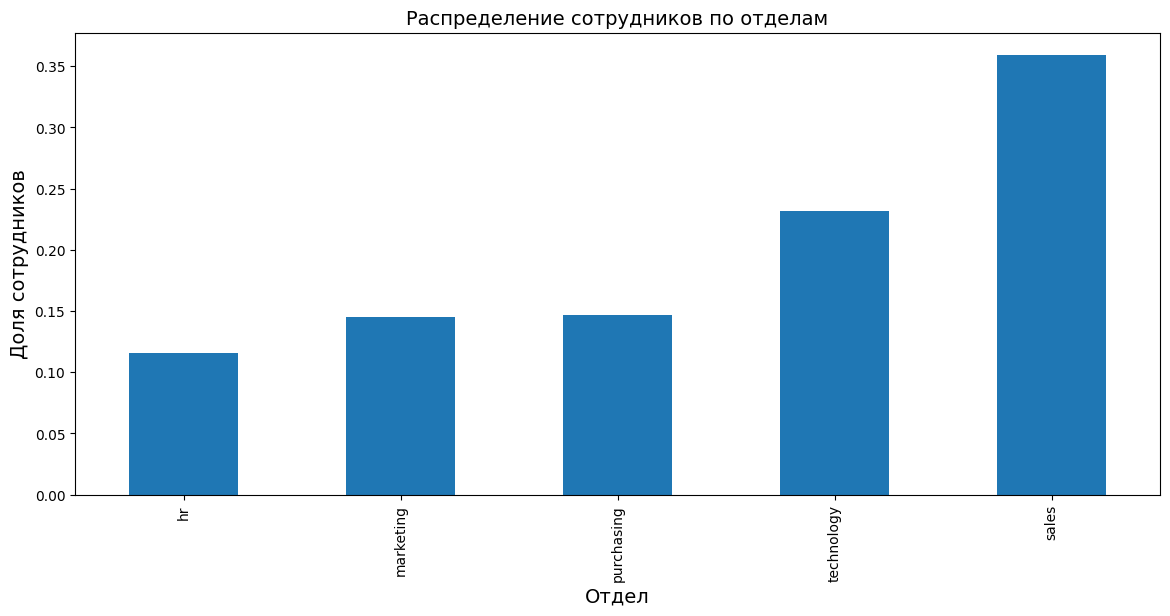

In [78]:
name = train_quit
col = "dept"
title = "Распределение сотрудников по отделам"
x = "Отдел"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Больше всего сотрудников работает в отделе продаж, примерно, 37%. Меньше всего в отделе по подбору персонала, примерно, 12%.

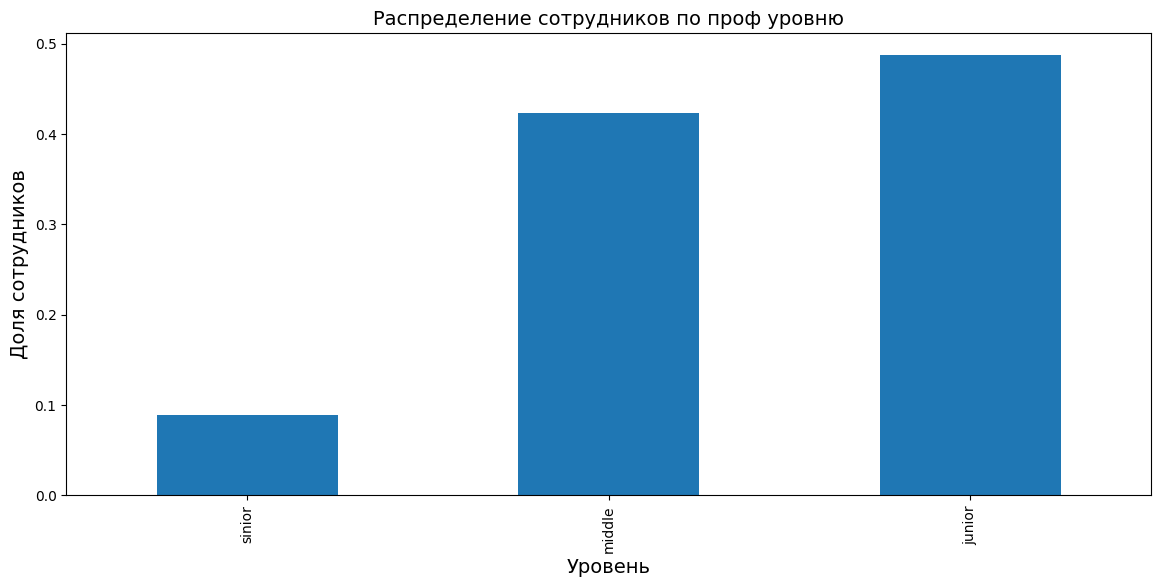

In [79]:
name = train_quit
col = "level"
title = "Распределение сотрудников по проф уровню"
x = "Уровень"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Джуниоров больше всего, практически половина от всех сотрудников, но мидлов, также, достаточно много, около 42%.

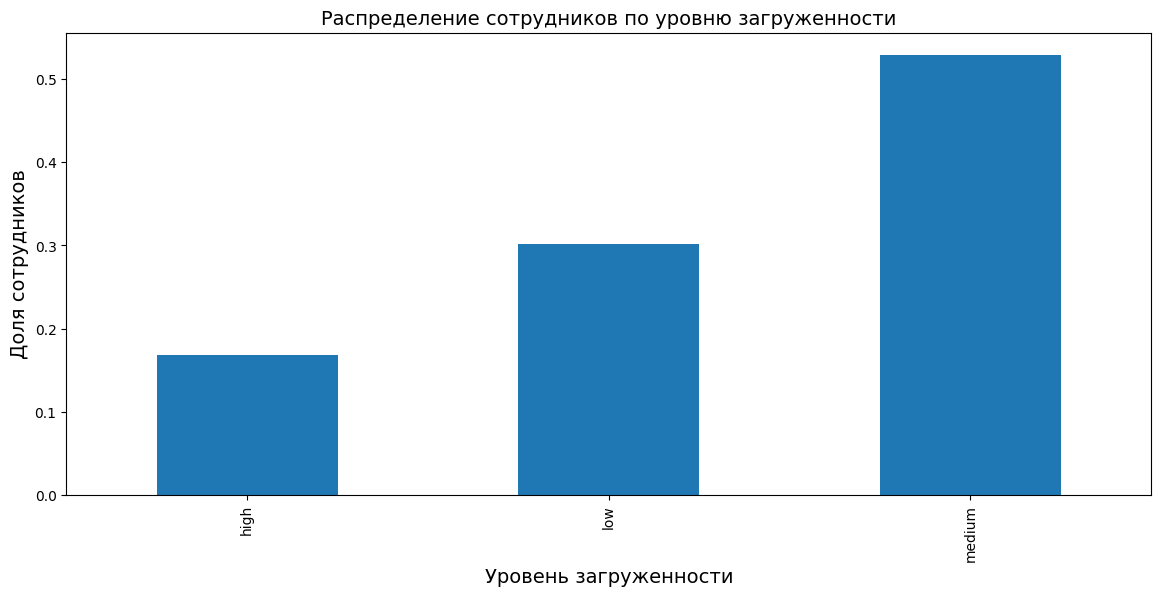

In [80]:
name = train_quit
col = "workload"
title = "Распределение сотрудников по уровню загруженности"
x = "Уровень загруженности"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Чуть более половины сотрудников средне загружены на работе. Но практически 20% - с высоким уровнем загруженности.

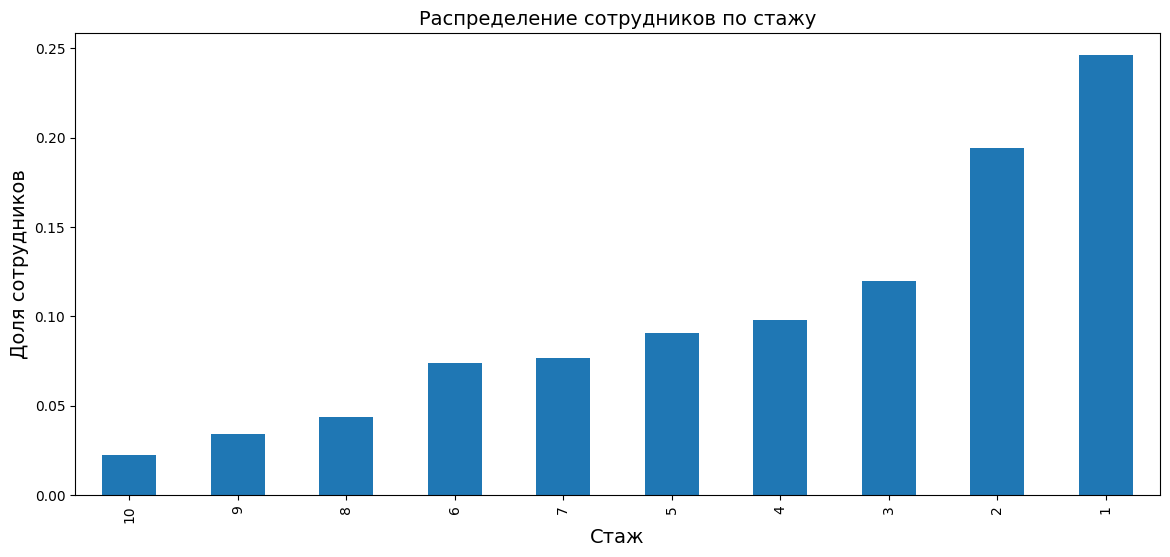

In [81]:
name = train_quit
col = "employment_years"
title = "Распределение сотрудников по стажу"
x = "Стаж"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Больше всего сотрудников с 1 и 2-годичным стажем, 10 лет в компании проработало около двух с половиной процентов от всех сотрудников.

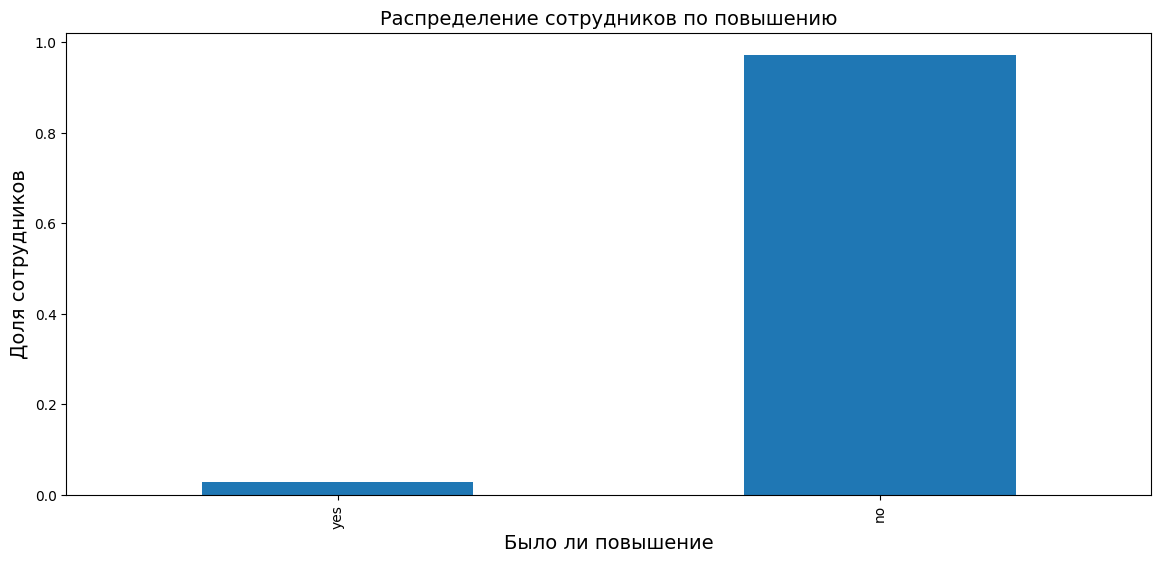

In [82]:
name = train_quit
col = "last_year_promo"
title = "Распределение сотрудников по повышению"
x = "Было ли повышение"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Только менее, чем у 1% сотрудников было повышение за последний год.

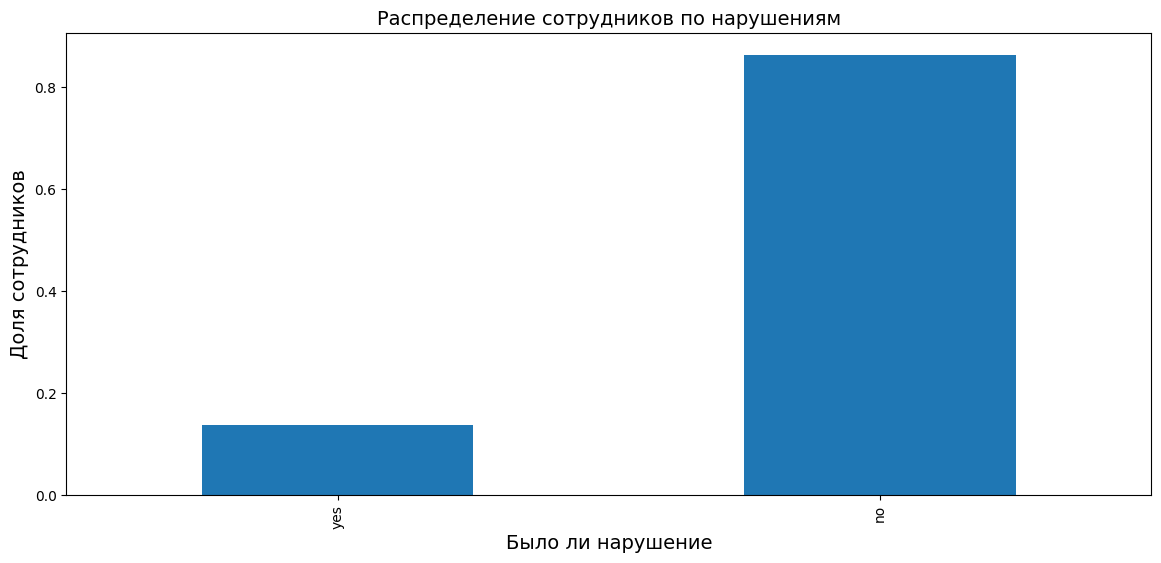

In [83]:
name = train_quit
col = "last_year_violations"
title = "Распределение сотрудников по нарушениям"
x = "Было ли нарушение"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Более 80% сотрудников не нарушало трудовой договор за последний год.

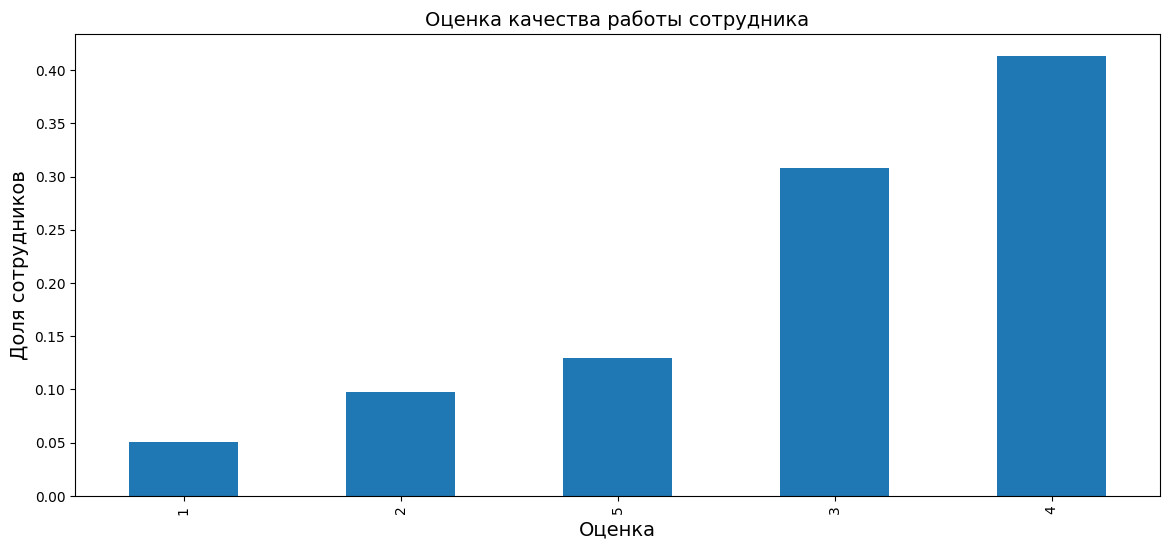

In [84]:
name = train_quit
col = "supervisor_evaluation"
title = "Оценка качества работы сотрудника"
x = "Оценка"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Руководители в большинстве случаев оценивают работу своих сотрудников 3 и 4 баллами. 5% сотрудников получили наименьший балл - 1.

In [85]:
def hist(name, col, title, x, y):
    ax = name[col].plot(kind='hist', bins=40,figsize=(15,7))
    ax.set_xlabel(x, fontsize=14)
    ax.set_ylabel(y, fontsize=14)

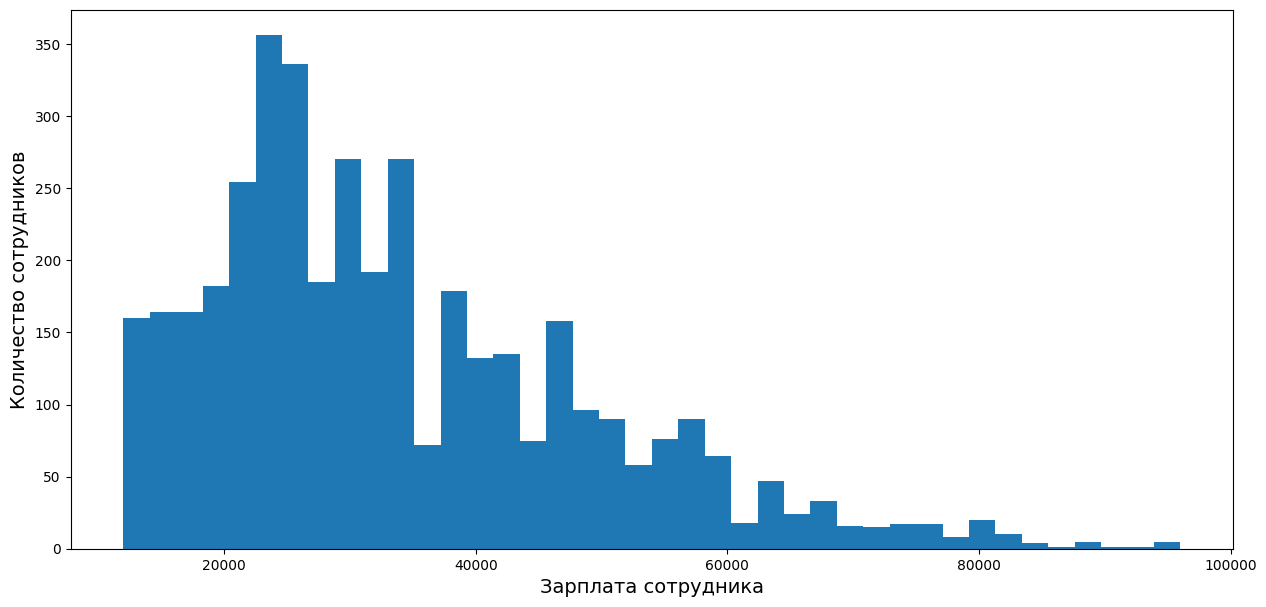

In [86]:
name = train_quit
col = "salary"
title = "Ежемесячная зарплата сотрудника"
x = "Зарплата сотрудника"
y = "Количество сотрудников"
hist(name, col, title, x, y)

Чаще всего среди сотрудников встречается заработная плата до 30000 руб.

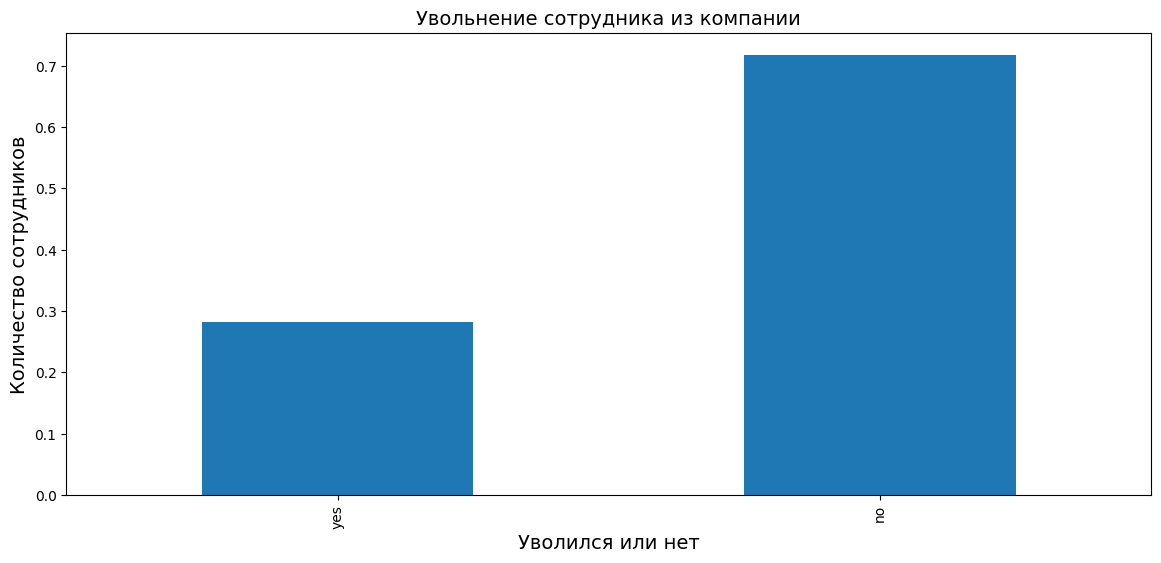

In [87]:
name = train_quit
col = "quit"
title = "Увольнение сотрудника из компании"
x = "Уволился или нет"
y = "Количество сотрудников"
histagram(name, col, title, x, y)

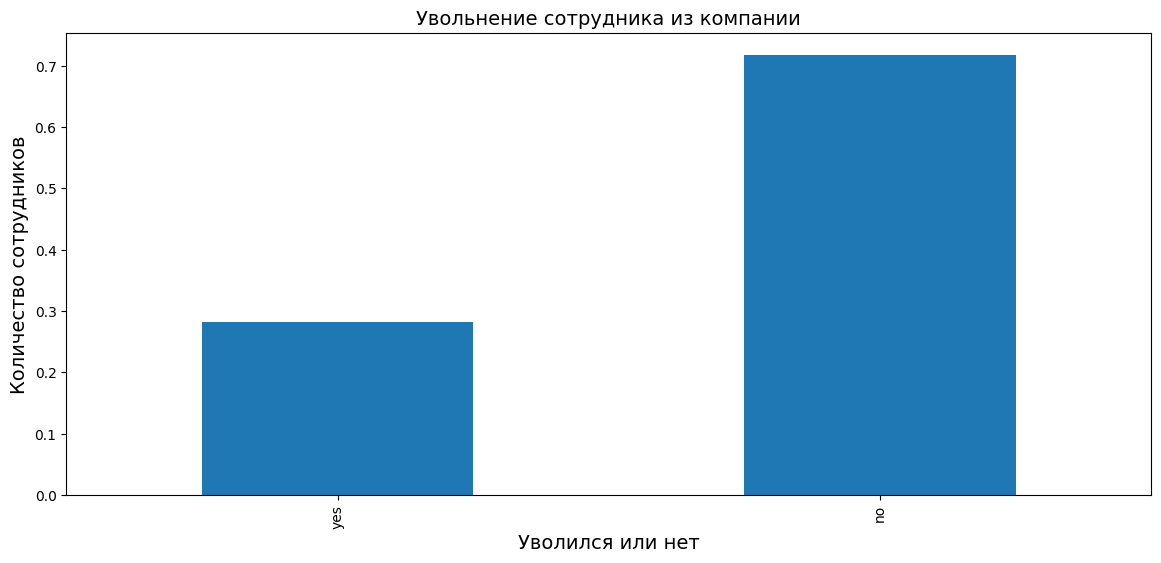

In [88]:
name = test_quit_target
col = "quit"
title = "Увольнение сотрудника из компании"
x = "Уволился или нет"
y = "Количество сотрудников"
histagram(name, col, title, x, y)

Практически 30% сотрудников, в итоге, уволилось из компании.

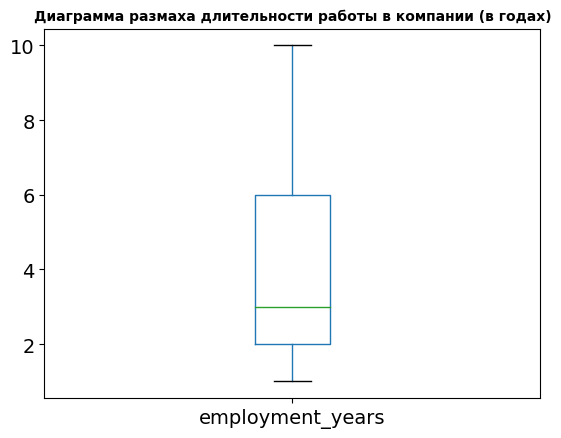

In [89]:
df = train_quit
col = 'employment_years'
title = 'Диаграмма размаха длительности работы в компании (в годах)'
plot(df, col, title)

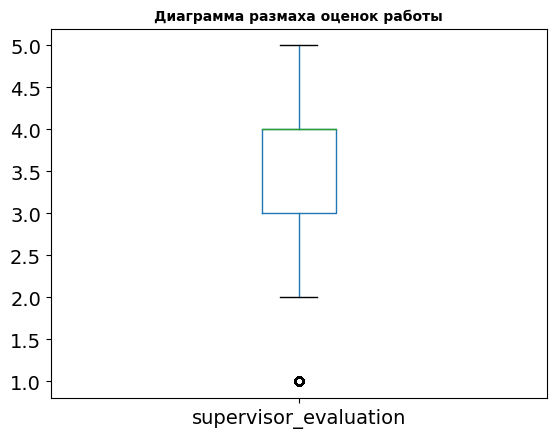

In [90]:
df = train_quit
col = 'supervisor_evaluation'
title = 'Диаграмма размаха оценок работы'
plot(df, col, title)

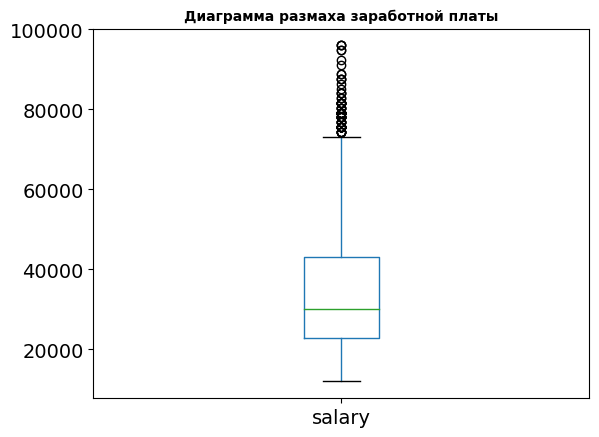

In [91]:
df = train_quit
col = 'salary'
title = 'Диаграмма размаха заработной платы'
plot(df, col, title)

Во всех столбцах с количественными признаками выбросов не обнаружено.

Так как корреляция Пирсона измеряет степень и направление линейных корреляций между переменными, а у нас зависимости между признаками нелинейные, нам подойдет корреляция Фи.

/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable quit for analysis 1. Dropping this column
  warnings.warn(


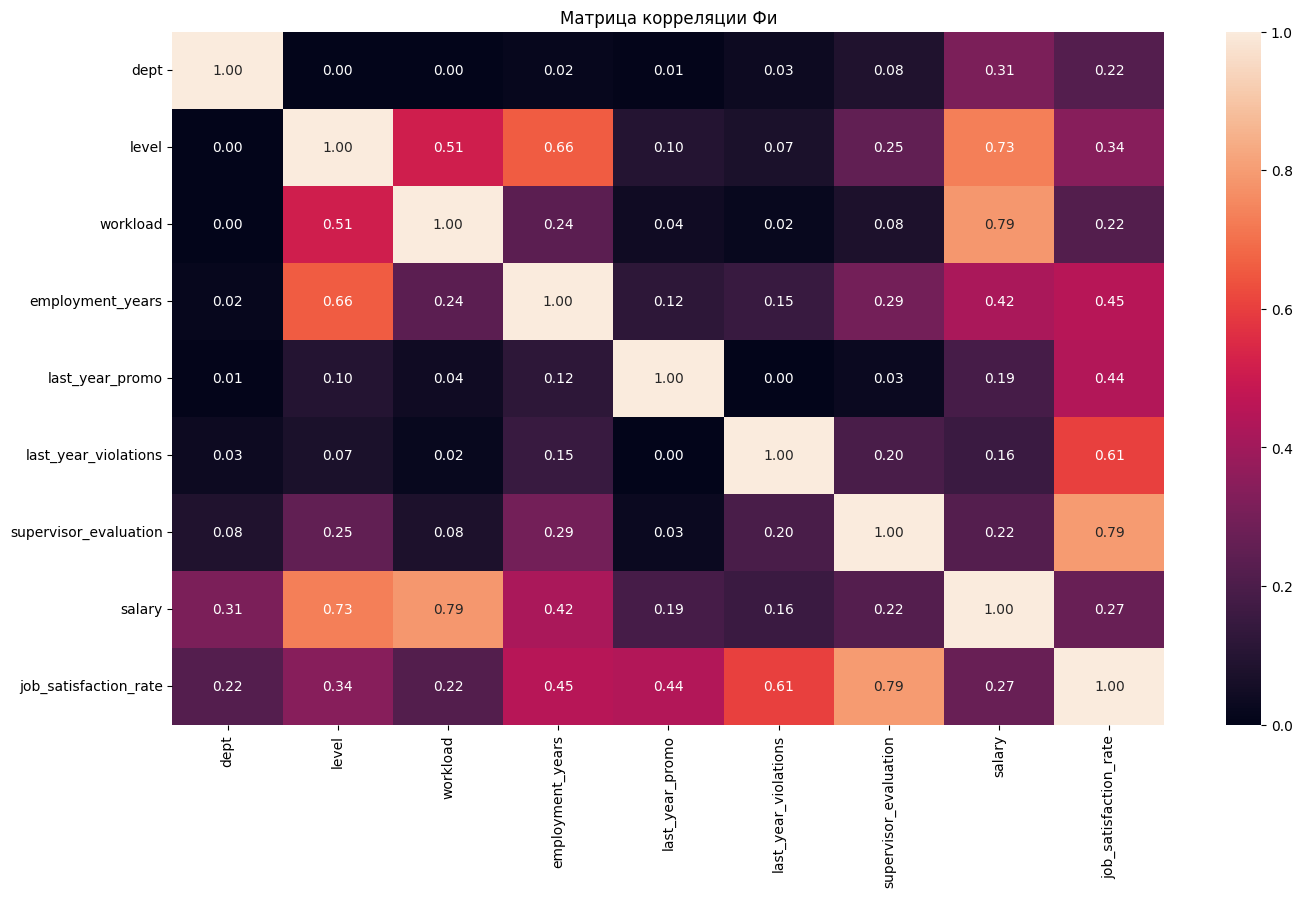

In [125]:
df_train_quit_without_id = train_quit.set_index('id')
interval_cols = ['salary', 'job_satisfaction_rate']
phik_matrix_0 = df_train_quit_without_id[df_train_quit_without_id['quit']==0]
phik_matrix_1 = phik_matrix_0.phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(16, 9))
sns.heatmap(phik_matrix_1, annot=True, fmt=".2f")
plt.title("Матрица корреляции Фи")
plt.show()

/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable quit for analysis 1. Dropping this column
  warnings.warn(


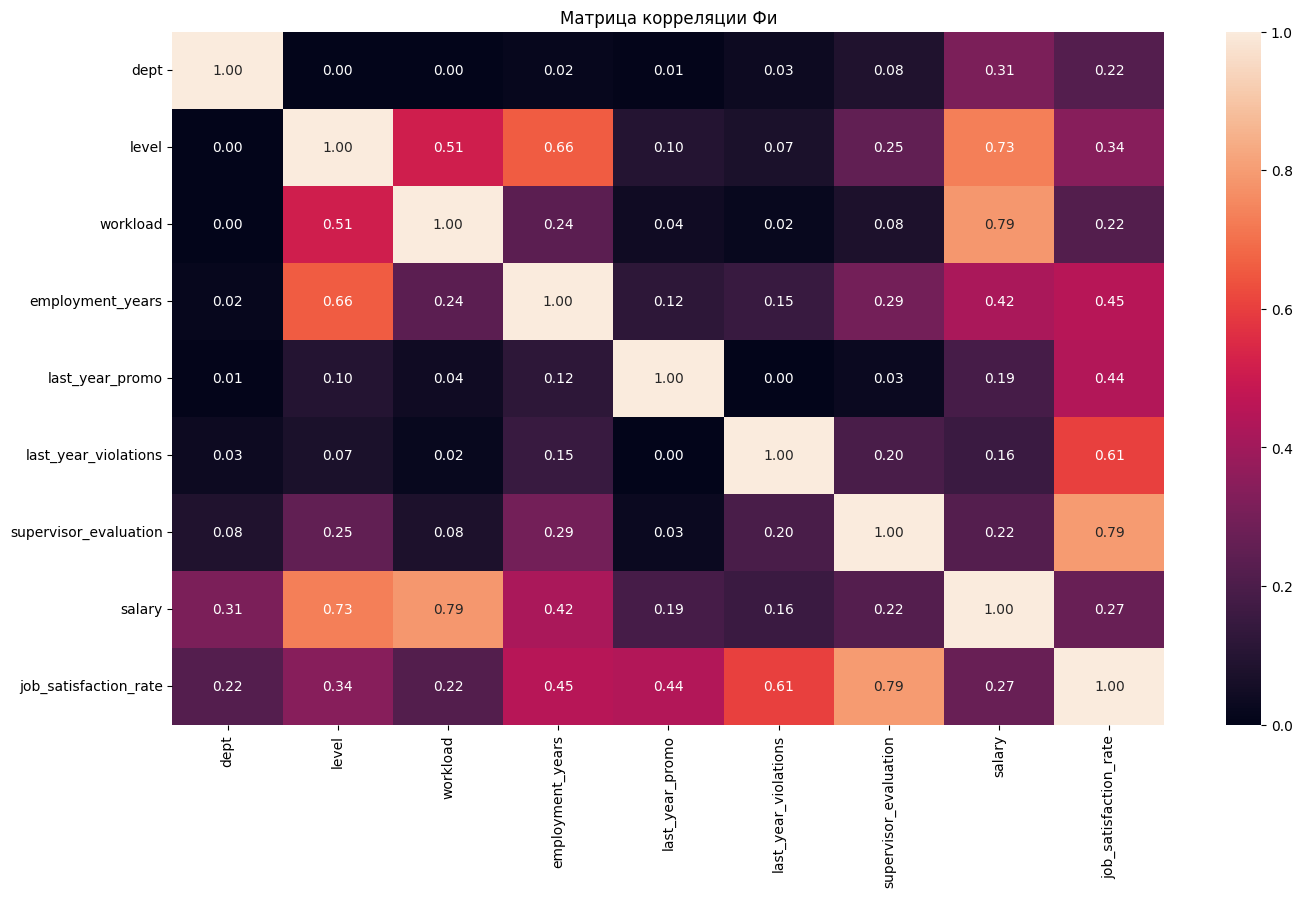

In [128]:
phik_matrix_2 = df_train_quit_without_id[df_train_quit_without_id['quit']!=1]
phik_matrix_3 = phik_matrix_2.phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(16, 9))
sns.heatmap(phik_matrix_3, annot=True, fmt=".2f")
plt.title("Матрица корреляции Фи")
plt.show()

Сильная положительная связь между признаками наблюдается между:  

з/п и уровнем занимаемой должности,  
з/п и уровнем загруженности сотрудника,  
оценкой работы и уровнем удовлетворения работой.  

Умеренная положительная связь между признаками наблюдается между:  

з/п и количеством уволившихся,
количеством уволившихся и стажем работы в компании,
количеством уволившихся и уровнем занимаеймой должности,
з/п и стажем в компании,  
уровнем удовлетворения работой и стажем в компании,  
уровнем удовлетворения работой и нарушением трудового договора,  
стажем в компании и уровнем занимаемой должности,  
уровнем загруженности сотрудника и департаментом.  

Между остальными признаками наблюдается слабая положительная связь.  

Мультиколлинеарности не наблюдается.

Составим портрет "уволившегося сотрудника". Для этого создадим дф только с уволившимися и сравним с разными признками сотрудников.

In [93]:
quiters = train_quit[train_quit['quit'] == 'yes']

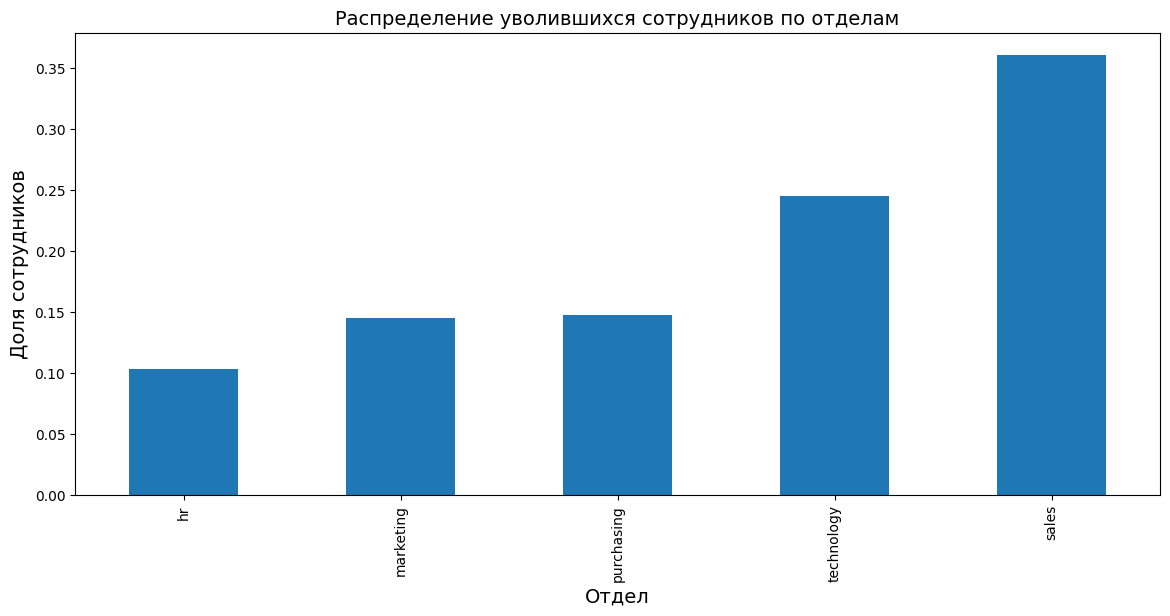

In [94]:
name = quiters
col = "dept"
title = "Распределение уволившихся сотрудников по отделам"
x = "Отдел"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Больше всего цволившихся из отдела продаж.

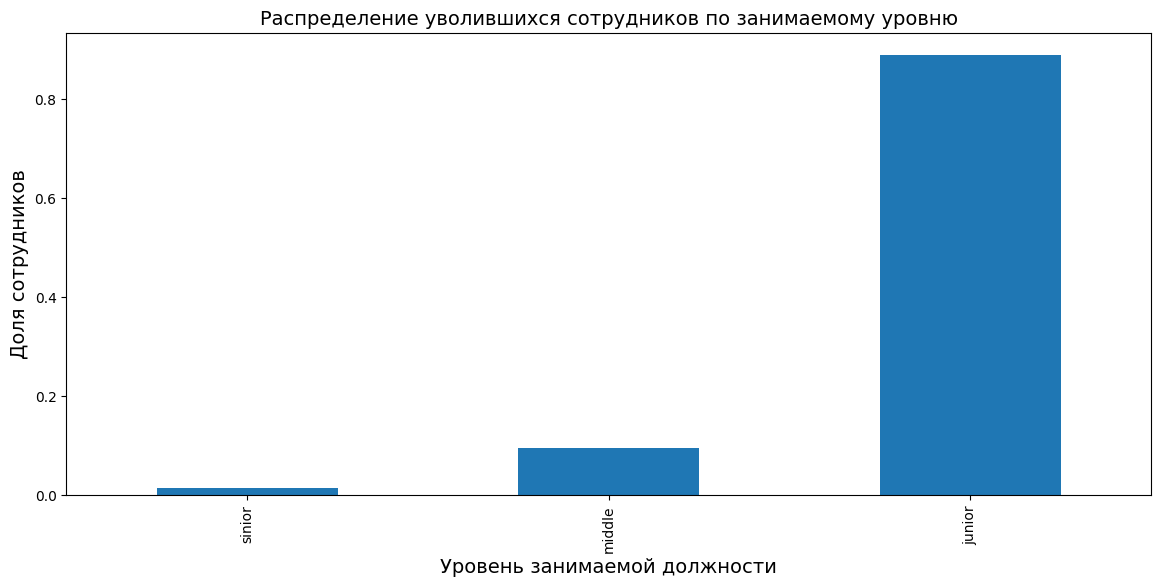

In [95]:
name = quiters
col = "level"
title = "Распределение уволившихся сотрудников по занимаемому уровню"
x = "Уровень занимаемой должности"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Больше всего уволившихся с уровнем должности - джуниор.

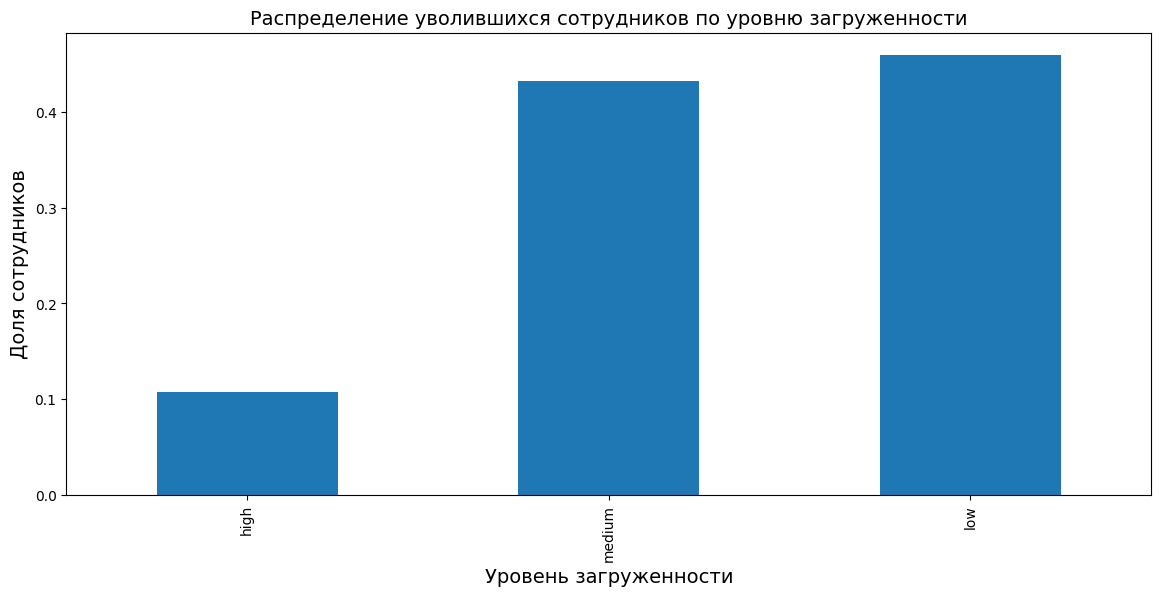

In [96]:
name = quiters
col = "workload"
title = "Распределение уволившихся сотрудников по уровню загруженности"
x = "Уровень загруженности"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Чаще всего сотрудники увольняются со слабым и средним уровнем загруженности на работе.

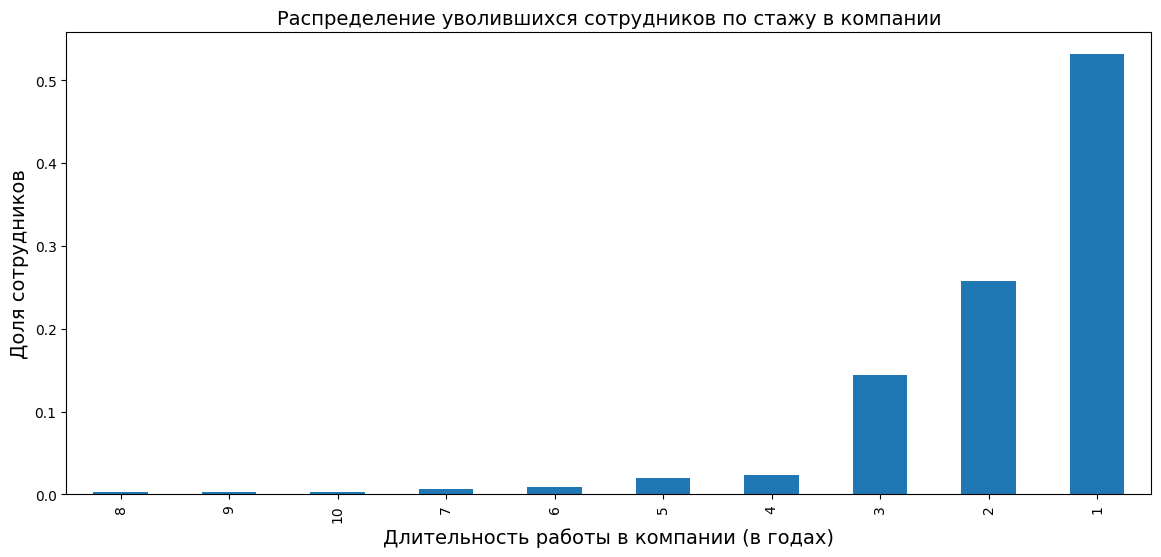

In [97]:
name = quiters
col = "employment_years"
title = "Распределение уволившихся сотрудников по стажу в компании"
x = "Длительность работы в компании (в годах)"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Чаще всего увольняются в первый год работы.

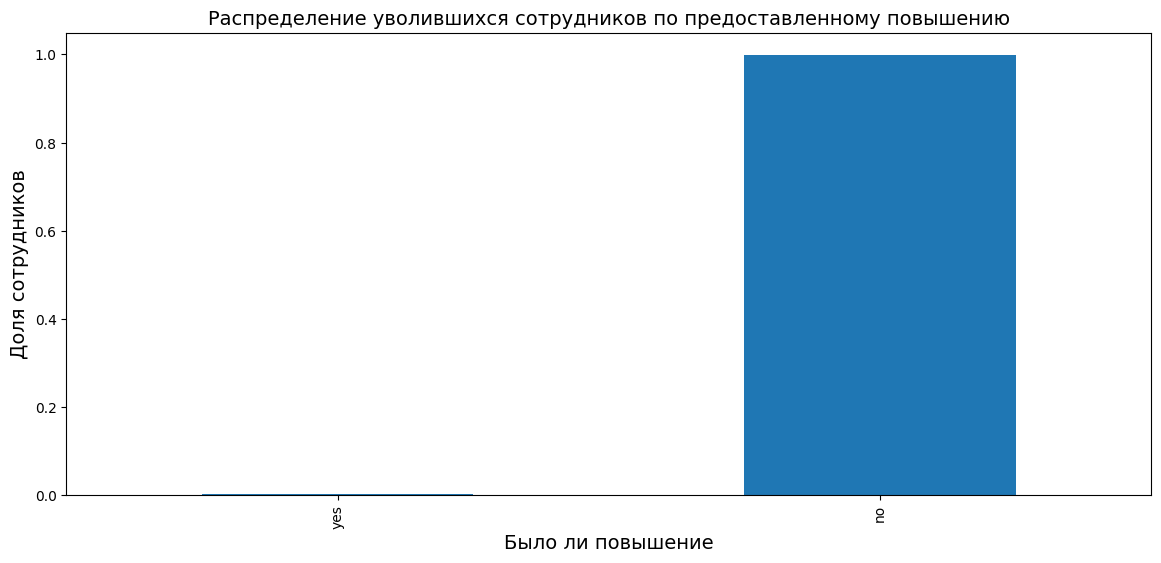

In [98]:
name = quiters
col = "last_year_promo"
title = "Распределение уволившихся сотрудников по предоставленному повышению"
x = "Было ли повышение"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Сотрудники после повышения практически не увольняются из компании.

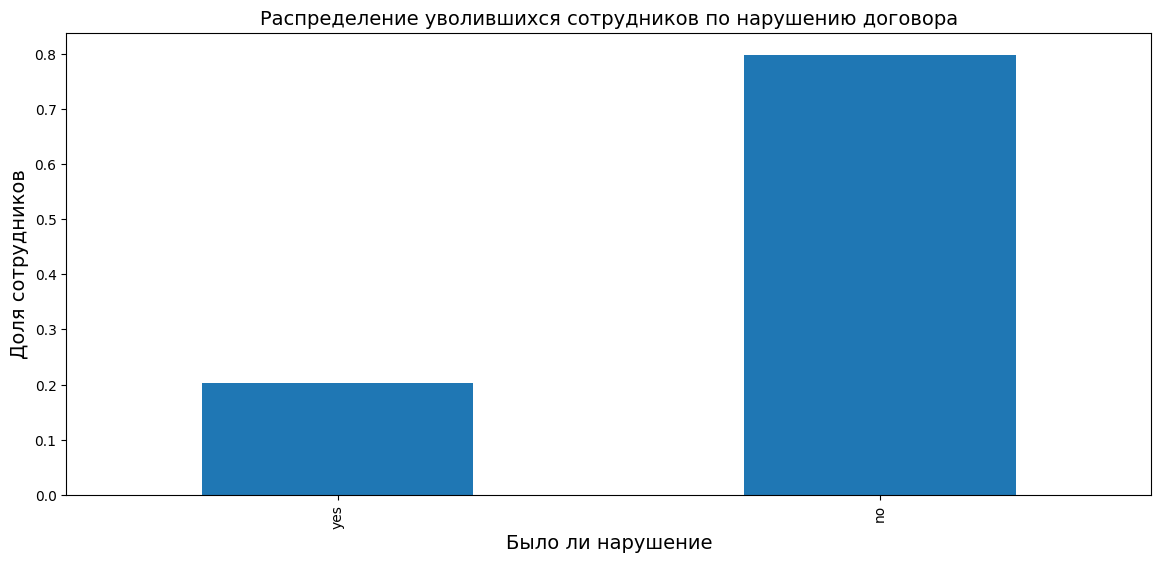

In [99]:
name = quiters
col = "last_year_violations"
title = "Распределение уволившихся сотрудников по нарушению договора"
x = "Было ли нарушение"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Чаще увольняются сотрудники, которые не нарушали трудовой договор.

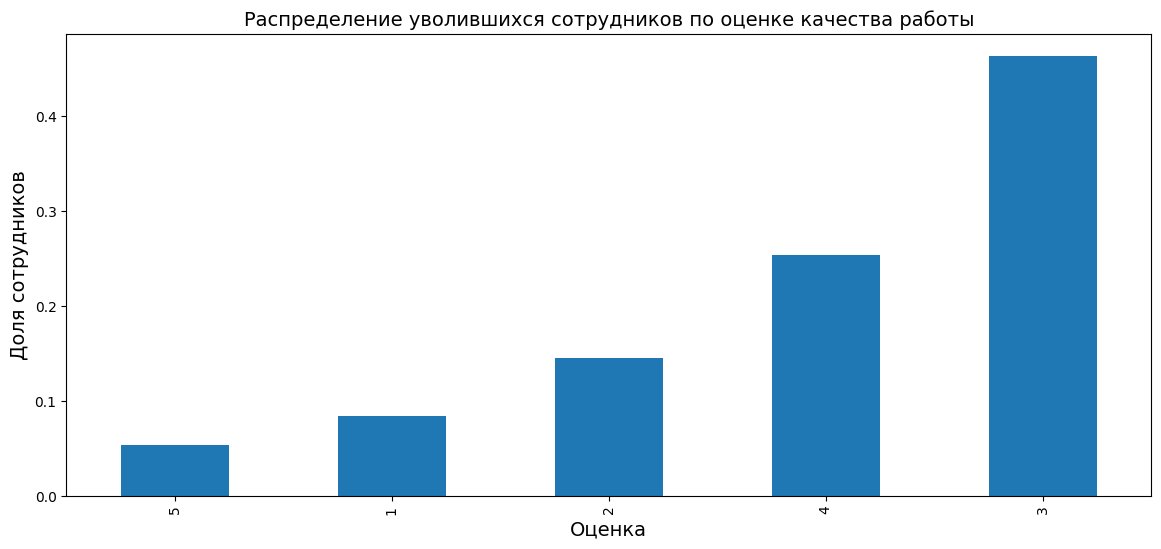

In [100]:
name = quiters
col = "supervisor_evaluation"
title = "Распределение уволившихся сотрудников по оценке качества работы"
x = "Оценка"
y = "Доля сотрудников"
histagram (name, col, title, x, y)

Чаще всего увольняются сотрудники, работу которых супервайзеры оценили в 3 балла.

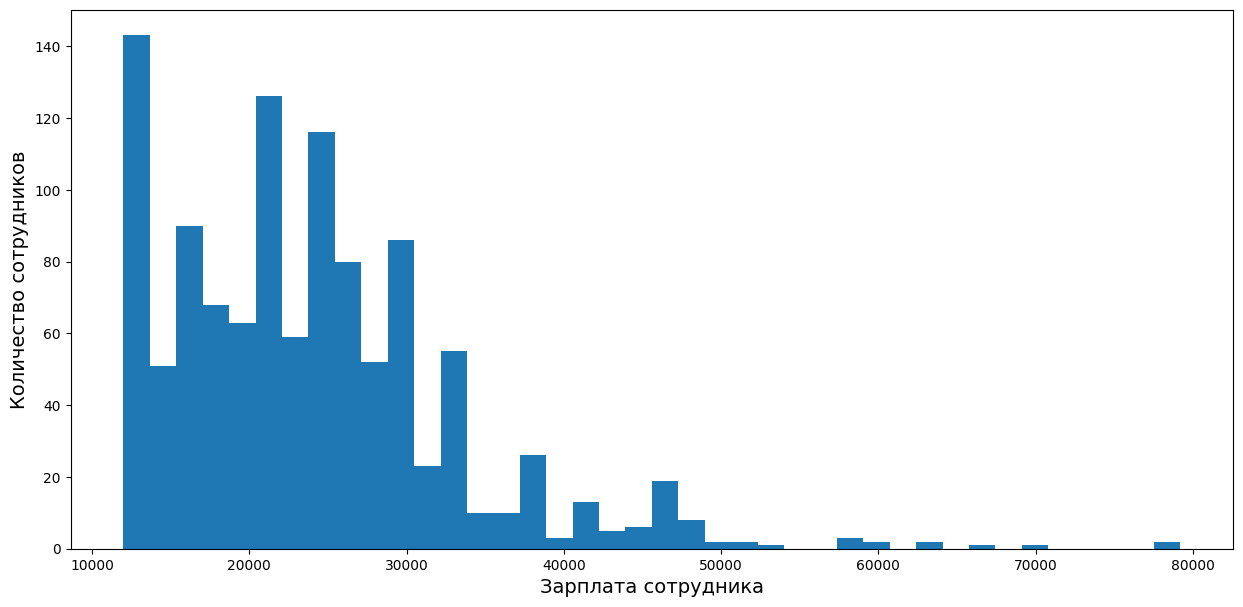

In [101]:
name = quiters
col = "salary"
title = "Ежемесячная зарплата уволившегося сотрудника"
x = "Зарплата сотрудника"
y = "Количество сотрудников"
hist(name, col, title, x, y)

В среднем, увольняются сотрудниуи с з/п до 30000 руб.

Типичный портрет уволившегося сотрудника - это человек с з/п до 30к руб, с оценкой работы в 3 балла, который не нарушал за последний год трудового договора, и не был повышен, работает в компании первый год на позиции джуна с низкой или средней стпенью нагруженности.

**Шаг 4. Добавление нового входного признака**

In [102]:
best_model = grid_search.best_estimator_
quiters['job_satisfaction_rate'] = best_model.predict(quiters)
quiters.head()

<ipython-input-102-01f0b31bea8b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quiters['job_satisfaction_rate'] = best_model.predict(quiters)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
5,699916,sales,junior,low,1,no,yes,3,18000,yes,0.180000
9,613206,technology,middle,medium,2,no,no,3,45600,yes,0.351111
24,468145,technology,junior,medium,2,no,no,3,30000,yes,0.374000
25,982346,marketing,junior,medium,3,no,no,3,30000,yes,0.460000


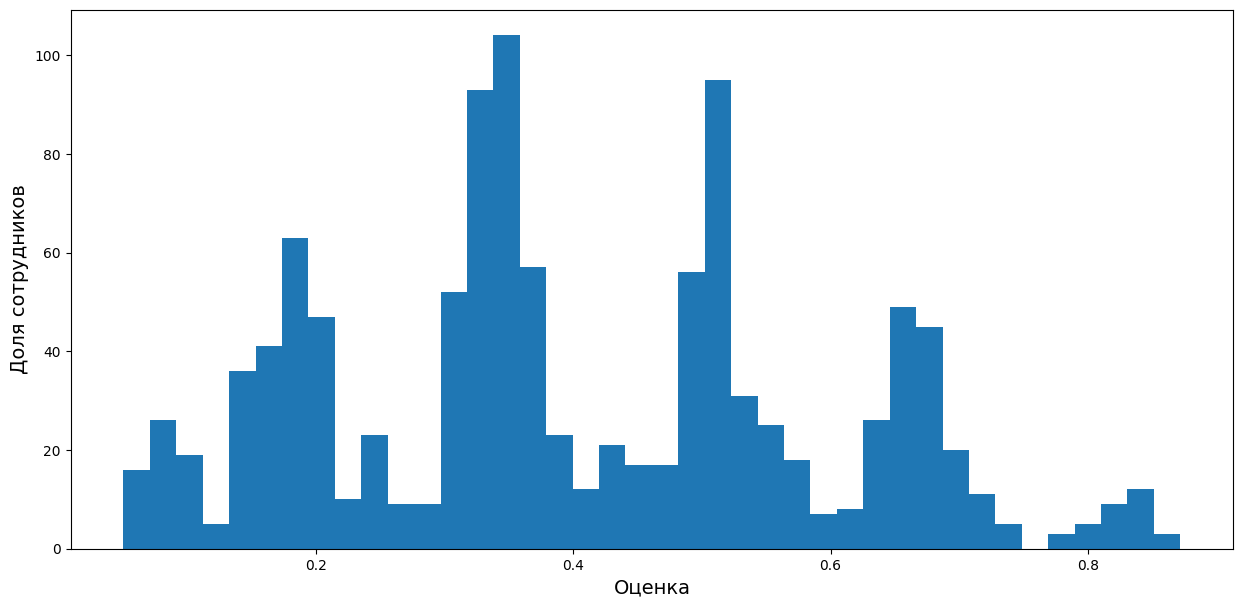

In [103]:
name = quiters
col = "job_satisfaction_rate"
title = "Распределение уволившихся сотрудников по оценке удовлетворенности работой"
x = "Оценка"
y = "Доля сотрудников"
hist(name, col, title, x, y)

In [104]:
train_quit['job_satisfaction_rate'] = best_model.predict(train_quit)

**Шаг 5. Подготовка данных**

In [105]:
train_quit_without_id = train_quit.drop(['id'], axis=1)
train_quit_without_id.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000,0.537677
std,2.541852,1.004049,15152.415163,0.218465
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.352188
50%,3.000000,4.000000,30000.000000,0.550000
75%,6.000000,4.000000,43200.000000,0.688750
max,10.000000,5.000000,96000.000000,1.000000


In [106]:
df_test['job_satisfaction_rate'] = best_model.predict(df_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [107]:
df_test_without_id = test_quit_target.drop(['id'], axis=1)


In [108]:
df_test_without_id.describe()

,quit
count,2000
unique,2
top,no
freq,1436


**Шаг 6. Обучение модели**

In [109]:
#train_quit['quit'] = train_quit['quit'].apply(lambda x: 1 if x =='yes' else 0)

In [110]:
df_target_merged = df_test_target.merge(df_test, on='id', how='left')
df_target_merged.head(5)

,id,job_satisfaction_rate_x,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_y
0,130604,0.74,technology,junior,medium,1,no,no,4,34800,0.690
1,825977,0.75,marketing,middle,high,7,no,no,5,58800,0.815
2,418490,0.60,purchasing,junior,low,1,no,no,4,19200,0.670
3,555320,0.72,technology,junior,medium,1,no,no,4,34800,0.690
4,826430,0.08,technology,junior,medium,1,no,yes,2,30000,0.180


In [111]:
df_target_merged.describe()

,id,job_satisfaction_rate_x,employment_years,supervisor_evaluation,salary,job_satisfaction_rate_y
count,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,0.54878,3.666500,3.526500,34066.800000,0.551315
std,253851.326129,0.22011,2.537222,0.996892,15398.436729,0.216001
min,100298.000000,0.03000,1.000000,1.000000,12000.000000,0.030000
25%,339052.000000,0.38000,1.000000,3.000000,22800.000000,0.370000
50%,550793.000000,0.58000,3.000000,4.000000,30000.000000,0.579091
75%,765763.750000,0.72000,6.000000,4.000000,43200.000000,0.695625
max,999029.000000,1.00000,10.000000,5.000000,96000.000000,1.000000


In [112]:
df_final = df_target_merged.merge(test_quit_target, on='id')
df_final.head(5)

,id,job_satisfaction_rate_x,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_y,quit
0,130604,0.74,technology,junior,medium,1,no,no,4,34800,0.690,no
1,825977,0.75,marketing,middle,high,7,no,no,5,58800,0.815,no
2,418490,0.60,purchasing,junior,low,1,no,no,4,19200,0.670,yes
3,555320,0.72,technology,junior,medium,1,no,no,4,34800,0.690,no
4,826430,0.08,technology,junior,medium,1,no,yes,2,30000,0.180,yes


In [113]:
df_final = df_final.rename(columns={'job_satisfaction_rate_x':'job_satisfaction_rate'})

In [114]:
train_2 = train_quit.drop(['id'], axis=1)
train_2.drop_duplicates(inplace=True)

In [145]:
RANDOM_STATE = 50
TEST_SIZE = 0.5
X_train_2 = train_2.drop('quit', axis=1)
y_train_2 = train_2['quit']
X_test_2 = df_final.drop(['quit','id'], axis=1)
y_test_2 = df_final['quit']


from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_2 = label_encoder.fit_transform(y_train_2)


In [146]:
X_test_2.head(5)

,job_satisfaction_rate,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_y
0,0.74,technology,junior,medium,1,no,no,4,34800,0.690
1,0.75,marketing,middle,high,7,no,no,5,58800,0.815
2,0.60,purchasing,junior,low,1,no,no,4,19200,0.670
3,0.72,technology,junior,medium,1,no,no,4,34800,0.690
4,0.08,technology,junior,medium,1,no,yes,2,30000,0.180


In [147]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [148]:
param_grid2 = [
      {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, min_samples_split=15, max_features=15)],
        'models__max_depth': range(10,30),
        'models__min_samples_leaf': range(10,30),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
      },

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 30),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

       {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 30),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

]

In [149]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore',))
    ]
    )
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [150]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [151]:
grid_search_2 = GridSearchCV(
    pipe_final,
    param_grid2,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
   )


In [152]:
grid_search_2.fit(X_train_2, y_train_2)
print('Лучшая модель и её параметры:\n\n', grid_search_2.best_estimator_)
print(f'Метрика лучшей модели на кросс-валидации: {grid_search_2.best_score_:.4f}')
y_test_pred = grid_search.predict(X_test_2)
print(f'Метрика ROC-AUC лучшей модели на обучающих данных: {round(grid_search_2.best_score_,4)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [123]:
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test_2, grid_search_2.predict_proba(X_test_2)[:, 1]),3)}')

Метрика ROC-AUC на тестовой выборке: 0.915


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [124]:
print('Гиперпараметры', grid_search_2.best_params_)

Гиперпараметры {'models': KNeighborsClassifier(), 'models__n_neighbors': 26, 'preprocessor__num': StandardScaler()}


**Шаг 7. Выводы**

Лучшая модель, которая точнее всего предсказывает увольнение сотрудника на тестовых данных - это KNeighborsClassifier с гиперпараметрами 'models__n_neighbors': 26, 'preprocessor__num': StandardScaler().   

Метрика ROC-AUC на тестовой выборке показывает значение 0.915, так как по условиям заказчика значение модели должно быть выше 9.1 , наша модель является рабочей и ее можно применять для предсказаний.

**Общий вывод**

1. Перед нами былло поставлено две задачи:
 - построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика,
 - построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
 Это очень важные данные для компании, тк поиск, обучение новых сотрудников, интеграция их в бизнес- очень большая статься расходов. Зная, какие признаки больше всего влияют на лояльность сотрудников к компании, руководство сможет влиять через них на текучку кадров.
 Обе модели показали хорошие результаты на тестовых данных. Это дает нам возможность предсказыват поведение сотрудников.
 2. Лучшая модель, которая предстказывает уровень удовлетворенности сотрудника: DecisionTreeRegressor
с параметрами random_state=42, models__max_depth: 13, odels__max_features: 11, preprocessor__num: MinMaxScaler.
Мы установили, что удовлетворенность сотрудника работой, действительно, влияет на его желание уйти из компании.   
Также, мы увидели на графиках, какие параметры больше всего влияют на степень удовлетворенности работой и составили типичный портрет уволившегося сотрудника.  

По этим данным можно сделать вывод, что компании необходимо обратить больше внимания на молодых специалистов, которые только что пришли в компанию. По каким-то причинам, им не удается влиться в бизнес и они увольняются в первый же год.   

Я бы порекомендавала HR проводить встречи с молодыми специалистами и отслиживать их настроения, выяснять оправдываются ли их ожидания от работы в данной компании. Можно разработать опросник и разослать новичкам, чтобы отследить общие недовольства, выявить слабые стороны и улучшить их, в зависимости от обратной связи сотрудников.  

Руководителям необходимо больше уделять внимания сотрудникам, с оценкой работы в 3 балла. Тк 2 и 1  - это достаточно низкие баллы и вряд ли есть смысл тратить силы на таких сотрудников, а вот 3 - это тот балл, который показывает, что сотрудник с большего с работой справляется , но где-то есть недочеты. Возможно, руководители мало помогают такому сегменту сотрудников до конца понять выполняемые задачи, предоставить дополнительное обучение в пробелах в знании и , возможно, иногда просто эмоционально поддержать. В итоге у сотрудника с оценкой 3 может падать мотивация в работе и повышаться желание перейти на новую.  

Необходимо обратить внимание на отдел продаж, тк большой отток сотрудников именно оттуда. Как правило, сейлс-менеджеры работают с минимальным окладом, который они знают при приеме на работу и на который соглашаются. Но большая часть их з/п состоит из бонусов и, возможно, бонусы, которые они ожидали получить - нереальны. Стоит пересмотреть систему оценки KPI, по итогу которой начисляются бонусы. Возможно, показатели завышены. Также, могут оказаться нереальными и цели выполнения задач для получения бонусов.

3. Мы нашли лучшую модель по предсказанию увольнения сотрудников. Ей оказалась KNeighborsClassifier с гиперпараметрами 'models__n_neighbors': 26, 'preprocessor__num': StandardScaler().
Метрика ROC-AUC на тестовой выборке показывает значение 0.915.

Это хороший показатель, по кторому бизнес сможет оценивать, как меняется количество теоритически уволившихся сотрудников после применения различных мер, улучшений и модернизаций направленных на повышение уровня удовлетворенности работой.

HR отдел сможет более точечно определять сотрудников в зоне риска и направлять усилия по удержанию(если необходимо) именно на таких сотрудников.